# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: first


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:01:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:01:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:01:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:02:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:02:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:02:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.7945910055565278
Average Accuracy: 0.7305133568807655
Average Precision: 0.6809919154288481
Average Recall: 0.5928331466965285


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:02:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:02:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:02:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:03:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:03:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7929288850639736
Average Accuracy: 0.7288536058434211
Average Precision: 0.6779277468719848
Average Recall: 0.5886450167973124


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))


[0]	validation_0-logloss:0.66580


[1]	validation_0-logloss:0.66326


[2]	validation_0-logloss:0.66082


[3]	validation_0-logloss:0.65820


[4]	validation_0-logloss:0.65546


[5]	validation_0-logloss:0.65334


[6]	validation_0-logloss:0.65080


[7]	validation_0-logloss:0.64857


[8]	validation_0-logloss:0.64616


[9]	validation_0-logloss:0.64347


[10]	validation_0-logloss:0.64096


[11]	validation_0-logloss:0.63859


[12]	validation_0-logloss:0.63611


[13]	validation_0-logloss:0.63420


[14]	validation_0-logloss:0.63203


[15]	validation_0-logloss:0.63009


[16]	validation_0-logloss:0.62766


[17]	validation_0-logloss:0.62545


[18]	validation_0-logloss:0.62385


[19]	validation_0-logloss:0.62198


[20]	validation_0-logloss:0.61983


[21]	validation_0-logloss:0.61852


[22]	validation_0-logloss:0.61669


[23]	validation_0-logloss:0.61487


[24]	validation_0-logloss:0.61333


[25]	validation_0-logloss:0.61177


[26]	validation_0-logloss:0.61067


[27]	validation_0-logloss:0.60924


[28]	validation_0-logloss:0.60760


[29]	validation_0-logloss:0.60565


[30]	validation_0-logloss:0.60425


[31]	validation_0-logloss:0.60268


[32]	validation_0-logloss:0.60107


[33]	validation_0-logloss:0.60011


[34]	validation_0-logloss:0.59873


[35]	validation_0-logloss:0.59681


[36]	validation_0-logloss:0.59548


[37]	validation_0-logloss:0.59422


[38]	validation_0-logloss:0.59287


[39]	validation_0-logloss:0.59166


[40]	validation_0-logloss:0.58955


[41]	validation_0-logloss:0.58790


[42]	validation_0-logloss:0.58641


[43]	validation_0-logloss:0.58508


[44]	validation_0-logloss:0.58375


[45]	validation_0-logloss:0.58304


[46]	validation_0-logloss:0.58150


[47]	validation_0-logloss:0.58034


[48]	validation_0-logloss:0.57898


[49]	validation_0-logloss:0.57757


[50]	validation_0-logloss:0.57625


[51]	validation_0-logloss:0.57509


[52]	validation_0-logloss:0.57374


[53]	validation_0-logloss:0.57243


[54]	validation_0-logloss:0.57155


[55]	validation_0-logloss:0.57010


[56]	validation_0-logloss:0.56902


[57]	validation_0-logloss:0.56788


[58]	validation_0-logloss:0.56696


[59]	validation_0-logloss:0.56572


[60]	validation_0-logloss:0.56468


[61]	validation_0-logloss:0.56372


[62]	validation_0-logloss:0.56257


[63]	validation_0-logloss:0.56154


[64]	validation_0-logloss:0.56034


[65]	validation_0-logloss:0.55955


[66]	validation_0-logloss:0.55834


[67]	validation_0-logloss:0.55785


[68]	validation_0-logloss:0.55656


[69]	validation_0-logloss:0.55585


[70]	validation_0-logloss:0.55535


[71]	validation_0-logloss:0.55432


[72]	validation_0-logloss:0.55377


[73]	validation_0-logloss:0.55259


[74]	validation_0-logloss:0.55178


[75]	validation_0-logloss:0.55170


[76]	validation_0-logloss:0.55123


[77]	validation_0-logloss:0.55012


[78]	validation_0-logloss:0.54924


[79]	validation_0-logloss:0.54840


[80]	validation_0-logloss:0.54704


[81]	validation_0-logloss:0.54653


[82]	validation_0-logloss:0.54523


[83]	validation_0-logloss:0.54441


[84]	validation_0-logloss:0.54297


[85]	validation_0-logloss:0.54220


[86]	validation_0-logloss:0.54131


[87]	validation_0-logloss:0.54018


[88]	validation_0-logloss:0.53913


[89]	validation_0-logloss:0.53849


[90]	validation_0-logloss:0.53758


[91]	validation_0-logloss:0.53714


[92]	validation_0-logloss:0.53680


[93]	validation_0-logloss:0.53611


[94]	validation_0-logloss:0.53527


[95]	validation_0-logloss:0.53469


[96]	validation_0-logloss:0.53425


[97]	validation_0-logloss:0.53394


[98]	validation_0-logloss:0.53369


[99]	validation_0-logloss:0.53298


[100]	validation_0-logloss:0.53260


[101]	validation_0-logloss:0.53175


[102]	validation_0-logloss:0.53094


[103]	validation_0-logloss:0.53005


[104]	validation_0-logloss:0.52976


[105]	validation_0-logloss:0.52919


[106]	validation_0-logloss:0.52846


[107]	validation_0-logloss:0.52780


[108]	validation_0-logloss:0.52741


[109]	validation_0-logloss:0.52680


[110]	validation_0-logloss:0.52625


[111]	validation_0-logloss:0.52577


[112]	validation_0-logloss:0.52487


[113]	validation_0-logloss:0.52445


[114]	validation_0-logloss:0.52419


[115]	validation_0-logloss:0.52371


[116]	validation_0-logloss:0.52312


[117]	validation_0-logloss:0.52239


[118]	validation_0-logloss:0.52208


[119]	validation_0-logloss:0.52152


[120]	validation_0-logloss:0.52138


[121]	validation_0-logloss:0.52078


[122]	validation_0-logloss:0.52039


[123]	validation_0-logloss:0.51992


[124]	validation_0-logloss:0.51942


[125]	validation_0-logloss:0.51915


[126]	validation_0-logloss:0.51918


[127]	validation_0-logloss:0.51889


[128]	validation_0-logloss:0.51868


[129]	validation_0-logloss:0.51847


[130]	validation_0-logloss:0.51729


[131]	validation_0-logloss:0.51721


[132]	validation_0-logloss:0.51685


[133]	validation_0-logloss:0.51621


[134]	validation_0-logloss:0.51581


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:03:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[135]	validation_0-logloss:0.51509


[136]	validation_0-logloss:0.51471


[137]	validation_0-logloss:0.51411


[138]	validation_0-logloss:0.51394


[139]	validation_0-logloss:0.51408


[140]	validation_0-logloss:0.51357


[141]	validation_0-logloss:0.51325


[142]	validation_0-logloss:0.51256


[143]	validation_0-logloss:0.51218


[144]	validation_0-logloss:0.51213


[145]	validation_0-logloss:0.51159


[146]	validation_0-logloss:0.51127


[147]	validation_0-logloss:0.51032


[148]	validation_0-logloss:0.50957


[149]	validation_0-logloss:0.50940


[150]	validation_0-logloss:0.50918


[151]	validation_0-logloss:0.50866


[152]	validation_0-logloss:0.50846


[153]	validation_0-logloss:0.50830


[154]	validation_0-logloss:0.50754


[155]	validation_0-logloss:0.50724


[156]	validation_0-logloss:0.50696


[157]	validation_0-logloss:0.50677


[158]	validation_0-logloss:0.50622


[159]	validation_0-logloss:0.50565


[160]	validation_0-logloss:0.50531


[161]	validation_0-logloss:0.50497


[162]	validation_0-logloss:0.50463


[163]	validation_0-logloss:0.50386


[164]	validation_0-logloss:0.50348


[165]	validation_0-logloss:0.50345


[166]	validation_0-logloss:0.50355


[167]	validation_0-logloss:0.50360


[168]	validation_0-logloss:0.50331


[169]	validation_0-logloss:0.50307


[170]	validation_0-logloss:0.50251


[171]	validation_0-logloss:0.50250


[172]	validation_0-logloss:0.50221


[173]	validation_0-logloss:0.50223


[174]	validation_0-logloss:0.50183


[175]	validation_0-logloss:0.50170


[176]	validation_0-logloss:0.50147


[177]	validation_0-logloss:0.50123


[178]	validation_0-logloss:0.50126


[179]	validation_0-logloss:0.50132


[180]	validation_0-logloss:0.50129


[181]	validation_0-logloss:0.50093


[182]	validation_0-logloss:0.50025


[183]	validation_0-logloss:0.50023


[184]	validation_0-logloss:0.49987


[185]	validation_0-logloss:0.49976


[186]	validation_0-logloss:0.49997


[187]	validation_0-logloss:0.49994


[188]	validation_0-logloss:0.49969


[189]	validation_0-logloss:0.49924


[190]	validation_0-logloss:0.49868


[191]	validation_0-logloss:0.49851


[192]	validation_0-logloss:0.49827


[193]	validation_0-logloss:0.49802


[194]	validation_0-logloss:0.49785


[195]	validation_0-logloss:0.49749


[196]	validation_0-logloss:0.49720


[197]	validation_0-logloss:0.49720


[198]	validation_0-logloss:0.49705


[199]	validation_0-logloss:0.49686


[200]	validation_0-logloss:0.49674


[201]	validation_0-logloss:0.49634


[202]	validation_0-logloss:0.49612


[203]	validation_0-logloss:0.49606


[204]	validation_0-logloss:0.49605


[205]	validation_0-logloss:0.49579


[206]	validation_0-logloss:0.49568


[207]	validation_0-logloss:0.49533


[208]	validation_0-logloss:0.49517


[209]	validation_0-logloss:0.49528


[210]	validation_0-logloss:0.49499


[211]	validation_0-logloss:0.49477


[212]	validation_0-logloss:0.49484


[213]	validation_0-logloss:0.49457


[214]	validation_0-logloss:0.49483


[215]	validation_0-logloss:0.49470


[216]	validation_0-logloss:0.49463


[217]	validation_0-logloss:0.49461


[218]	validation_0-logloss:0.49426


[219]	validation_0-logloss:0.49395


[220]	validation_0-logloss:0.49383


[221]	validation_0-logloss:0.49413


[222]	validation_0-logloss:0.49395


[223]	validation_0-logloss:0.49358


[224]	validation_0-logloss:0.49340


[225]	validation_0-logloss:0.49328


[226]	validation_0-logloss:0.49321


[227]	validation_0-logloss:0.49323


[228]	validation_0-logloss:0.49312


[229]	validation_0-logloss:0.49291


[230]	validation_0-logloss:0.49281


[231]	validation_0-logloss:0.49254


[232]	validation_0-logloss:0.49231


[233]	validation_0-logloss:0.49221


[234]	validation_0-logloss:0.49199


[235]	validation_0-logloss:0.49210


[236]	validation_0-logloss:0.49225


[237]	validation_0-logloss:0.49193


[238]	validation_0-logloss:0.49194


[239]	validation_0-logloss:0.49183


[240]	validation_0-logloss:0.49183


[241]	validation_0-logloss:0.49168


[242]	validation_0-logloss:0.49132


[243]	validation_0-logloss:0.49132


[244]	validation_0-logloss:0.49124


[245]	validation_0-logloss:0.49132


[246]	validation_0-logloss:0.49102


[247]	validation_0-logloss:0.49079


[248]	validation_0-logloss:0.49073


[249]	validation_0-logloss:0.49057


[250]	validation_0-logloss:0.49032

[251]	validation_0-logloss:0.49017


[252]	validation_0-logloss:0.48990


[253]	validation_0-logloss:0.48998


[254]	validation_0-logloss:0.48965


[255]	validation_0-logloss:0.48940


[256]	validation_0-logloss:0.48940


[257]	validation_0-logloss:0.48913


[258]	validation_0-logloss:0.48892

[259]	validation_0-logloss:0.48850


[260]	validation_0-logloss:0.48852


[261]	validation_0-logloss:0.48861


[262]	validation_0-logloss:0.48843

[263]	validation_0-logloss:0.48806


[264]	validation_0-logloss:0.48842

[265]	validation_0-logloss:0.48827


[266]	validation_0-logloss:0.48824


[267]	validation_0-logloss:0.48817


[268]	validation_0-logloss:0.48820


[269]	validation_0-logloss:0.48817


[270]	validation_0-logloss:0.48820


[271]	validation_0-logloss:0.48818


[272]	validation_0-logloss:0.48823


[0]	validation_0-logloss:0.66834


[1]	validation_0-logloss:0.66569


[2]	validation_0-logloss:0.66334


[3]	validation_0-logloss:0.66141


[4]	validation_0-logloss:0.65863


[5]	validation_0-logloss:0.65623


[6]	validation_0-logloss:0.65393


[7]	validation_0-logloss:0.65161


[8]	validation_0-logloss:0.64982


[9]	validation_0-logloss:0.64743


[10]	validation_0-logloss:0.64534


[11]	validation_0-logloss:0.64334


[12]	validation_0-logloss:0.64141


[13]	validation_0-logloss:0.63977


[14]	validation_0-logloss:0.63788


[15]	validation_0-logloss:0.63619


[16]	validation_0-logloss:0.63505


[17]	validation_0-logloss:0.63333


[18]	validation_0-logloss:0.63135


[19]	validation_0-logloss:0.62946


[20]	validation_0-logloss:0.62814


[21]	validation_0-logloss:0.62586


[22]	validation_0-logloss:0.62437


[23]	validation_0-logloss:0.62244


[24]	validation_0-logloss:0.62020


[25]	validation_0-logloss:0.61846


[26]	validation_0-logloss:0.61711


[27]	validation_0-logloss:0.61560


[28]	validation_0-logloss:0.61433


[29]	validation_0-logloss:0.61263


[30]	validation_0-logloss:0.61087


[31]	validation_0-logloss:0.60948


[32]	validation_0-logloss:0.60809


[33]	validation_0-logloss:0.60628


[34]	validation_0-logloss:0.60476


[35]	validation_0-logloss:0.60296


[36]	validation_0-logloss:0.60130


[37]	validation_0-logloss:0.60006


[38]	validation_0-logloss:0.59853


[39]	validation_0-logloss:0.59663


[40]	validation_0-logloss:0.59567


[41]	validation_0-logloss:0.59473


[42]	validation_0-logloss:0.59328


[43]	validation_0-logloss:0.59236


[44]	validation_0-logloss:0.59093


[45]	validation_0-logloss:0.58982


[46]	validation_0-logloss:0.58872


[47]	validation_0-logloss:0.58743


[48]	validation_0-logloss:0.58631


[49]	validation_0-logloss:0.58558


[50]	validation_0-logloss:0.58463


[51]	validation_0-logloss:0.58294


[52]	validation_0-logloss:0.58191


[53]	validation_0-logloss:0.58112


[54]	validation_0-logloss:0.58017


[55]	validation_0-logloss:0.57941


[56]	validation_0-logloss:0.57849


[57]	validation_0-logloss:0.57776


[58]	validation_0-logloss:0.57683


[59]	validation_0-logloss:0.57584


[60]	validation_0-logloss:0.57504


[61]	validation_0-logloss:0.57365


[62]	validation_0-logloss:0.57239


[63]	validation_0-logloss:0.57162


[64]	validation_0-logloss:0.57108


[65]	validation_0-logloss:0.57057


[66]	validation_0-logloss:0.56969


[67]	validation_0-logloss:0.56935


[68]	validation_0-logloss:0.56893


[69]	validation_0-logloss:0.56806


[70]	validation_0-logloss:0.56703


[71]	validation_0-logloss:0.56587


[72]	validation_0-logloss:0.56544


[73]	validation_0-logloss:0.56461


[74]	validation_0-logloss:0.56380


[75]	validation_0-logloss:0.56280


[76]	validation_0-logloss:0.56252


[77]	validation_0-logloss:0.56168


[78]	validation_0-logloss:0.56088


[79]	validation_0-logloss:0.55980


[80]	validation_0-logloss:0.55923


[81]	validation_0-logloss:0.55848


[82]	validation_0-logloss:0.55782


[83]	validation_0-logloss:0.55721


[84]	validation_0-logloss:0.55666


[85]	validation_0-logloss:0.55618


[86]	validation_0-logloss:0.55571


[87]	validation_0-logloss:0.55493


[88]	validation_0-logloss:0.55412


[89]	validation_0-logloss:0.55357


[90]	validation_0-logloss:0.55289


[91]	validation_0-logloss:0.55224


[92]	validation_0-logloss:0.55173


[93]	validation_0-logloss:0.55079


[94]	validation_0-logloss:0.55007


[95]	validation_0-logloss:0.54990


[96]	validation_0-logloss:0.54955


[97]	validation_0-logloss:0.54864


[98]	validation_0-logloss:0.54797


[99]	validation_0-logloss:0.54717


[100]	validation_0-logloss:0.54680


[101]	validation_0-logloss:0.54659


[102]	validation_0-logloss:0.54614


[103]	validation_0-logloss:0.54565


[104]	validation_0-logloss:0.54497


[105]	validation_0-logloss:0.54427


[106]	validation_0-logloss:0.54376


[107]	validation_0-logloss:0.54335


[108]	validation_0-logloss:0.54283


[109]	validation_0-logloss:0.54195


[110]	validation_0-logloss:0.54108


[111]	validation_0-logloss:0.54071


[112]	validation_0-logloss:0.53996


[113]	validation_0-logloss:0.53945


[114]	validation_0-logloss:0.53891


[115]	validation_0-logloss:0.53836


[116]	validation_0-logloss:0.53828


[117]	validation_0-logloss:0.53792


[118]	validation_0-logloss:0.53726


[119]	validation_0-logloss:0.53693


[120]	validation_0-logloss:0.53636


[121]	validation_0-logloss:0.53549


[122]	validation_0-logloss:0.53476


[123]	validation_0-logloss:0.53426


[124]	validation_0-logloss:0.53364


[125]	validation_0-logloss:0.53317


[126]	validation_0-logloss:0.53281


[127]	validation_0-logloss:0.53252


[128]	validation_0-logloss:0.53189


[129]	validation_0-logloss:0.53136


[130]	validation_0-logloss:0.53072


[131]	validation_0-logloss:0.53020


[132]	validation_0-logloss:0.52973


[133]	validation_0-logloss:0.52974


[134]	validation_0-logloss:0.52925


[135]	validation_0-logloss:0.52875


[136]	validation_0-logloss:0.52850


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:03:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[137]	validation_0-logloss:0.52822


[138]	validation_0-logloss:0.52827


[139]	validation_0-logloss:0.52773


[140]	validation_0-logloss:0.52727


[141]	validation_0-logloss:0.52697


[142]	validation_0-logloss:0.52639


[143]	validation_0-logloss:0.52585


[144]	validation_0-logloss:0.52567


[145]	validation_0-logloss:0.52517


[146]	validation_0-logloss:0.52518


[147]	validation_0-logloss:0.52497


[148]	validation_0-logloss:0.52490


[149]	validation_0-logloss:0.52421


[150]	validation_0-logloss:0.52397


[151]	validation_0-logloss:0.52356


[152]	validation_0-logloss:0.52314


[153]	validation_0-logloss:0.52281


[154]	validation_0-logloss:0.52245


[155]	validation_0-logloss:0.52230


[156]	validation_0-logloss:0.52208


[157]	validation_0-logloss:0.52203


[158]	validation_0-logloss:0.52180


[159]	validation_0-logloss:0.52156


[160]	validation_0-logloss:0.52149


[161]	validation_0-logloss:0.52134


[162]	validation_0-logloss:0.52128


[163]	validation_0-logloss:0.52079


[164]	validation_0-logloss:0.52052


[165]	validation_0-logloss:0.52038


[166]	validation_0-logloss:0.51976


[167]	validation_0-logloss:0.51954


[168]	validation_0-logloss:0.51950


[169]	validation_0-logloss:0.51927


[170]	validation_0-logloss:0.51926


[171]	validation_0-logloss:0.51910


[172]	validation_0-logloss:0.51871


[173]	validation_0-logloss:0.51811


[174]	validation_0-logloss:0.51791


[175]	validation_0-logloss:0.51759


[176]	validation_0-logloss:0.51740


[177]	validation_0-logloss:0.51718


[178]	validation_0-logloss:0.51718


[179]	validation_0-logloss:0.51699


[180]	validation_0-logloss:0.51647


[181]	validation_0-logloss:0.51606


[182]	validation_0-logloss:0.51599


[183]	validation_0-logloss:0.51598


[184]	validation_0-logloss:0.51612


[185]	validation_0-logloss:0.51597


[186]	validation_0-logloss:0.51577


[187]	validation_0-logloss:0.51567


[188]	validation_0-logloss:0.51557


[189]	validation_0-logloss:0.51547


[190]	validation_0-logloss:0.51544


[191]	validation_0-logloss:0.51508


[192]	validation_0-logloss:0.51485


[193]	validation_0-logloss:0.51450


[194]	validation_0-logloss:0.51433


[195]	validation_0-logloss:0.51437


[196]	validation_0-logloss:0.51444


[197]	validation_0-logloss:0.51459


[198]	validation_0-logloss:0.51441


[199]	validation_0-logloss:0.51409


[200]	validation_0-logloss:0.51416


[201]	validation_0-logloss:0.51407


[202]	validation_0-logloss:0.51408


[203]	validation_0-logloss:0.51399


[204]	validation_0-logloss:0.51369


[205]	validation_0-logloss:0.51351


[206]	validation_0-logloss:0.51325


[207]	validation_0-logloss:0.51323


[208]	validation_0-logloss:0.51303


[209]	validation_0-logloss:0.51288


[210]	validation_0-logloss:0.51295


[211]	validation_0-logloss:0.51290


[212]	validation_0-logloss:0.51279


[213]	validation_0-logloss:0.51308


[214]	validation_0-logloss:0.51316


[215]	validation_0-logloss:0.51292


[216]	validation_0-logloss:0.51245


[217]	validation_0-logloss:0.51199


[218]	validation_0-logloss:0.51176


[219]	validation_0-logloss:0.51173


[220]	validation_0-logloss:0.51180


[221]	validation_0-logloss:0.51196


[222]	validation_0-logloss:0.51171


[223]	validation_0-logloss:0.51146


[224]	validation_0-logloss:0.51125


[225]	validation_0-logloss:0.51115


[226]	validation_0-logloss:0.51118


[227]	validation_0-logloss:0.51104


[228]	validation_0-logloss:0.51113


[229]	validation_0-logloss:0.51133

[230]	validation_0-logloss:0.51091


[231]	validation_0-logloss:0.51080


[232]	validation_0-logloss:0.51084


[233]	validation_0-logloss:0.51061


[234]	validation_0-logloss:0.51047


[235]	validation_0-logloss:0.51040


[236]	validation_0-logloss:0.51032


[237]	validation_0-logloss:0.51028


[238]	validation_0-logloss:0.51036


[239]	validation_0-logloss:0.51009


[240]	validation_0-logloss:0.51035


[241]	validation_0-logloss:0.51026


[242]	validation_0-logloss:0.51005


[243]	validation_0-logloss:0.51016


[244]	validation_0-logloss:0.51002


[245]	validation_0-logloss:0.50977


[246]	validation_0-logloss:0.50976


[247]	validation_0-logloss:0.50965


[248]	validation_0-logloss:0.50961


[249]	validation_0-logloss:0.50954

[250]	validation_0-logloss:0.50975


[251]	validation_0-logloss:0.50924


[252]	validation_0-logloss:0.50936


[253]	validation_0-logloss:0.50933


[254]	validation_0-logloss:0.50902


[255]	validation_0-logloss:0.50892

[256]	validation_0-logloss:0.50864


[257]	validation_0-logloss:0.50871


[258]	validation_0-logloss:0.50877


[259]	validation_0-logloss:0.50866


[260]	validation_0-logloss:0.50862


[261]	validation_0-logloss:0.50849


[262]	validation_0-logloss:0.50829


[263]	validation_0-logloss:0.50820


[264]	validation_0-logloss:0.50848


[265]	validation_0-logloss:0.50854


[266]	validation_0-logloss:0.50847


[267]	validation_0-logloss:0.50851

[268]	validation_0-logloss:0.50815


[269]	validation_0-logloss:0.50808


[270]	validation_0-logloss:0.50787


[271]	validation_0-logloss:0.50773


[272]	validation_0-logloss:0.50765


[273]	validation_0-logloss:0.50732


[274]	validation_0-logloss:0.50718


[275]	validation_0-logloss:0.50718


[276]	validation_0-logloss:0.50721


[277]	validation_0-logloss:0.50708


[278]	validation_0-logloss:0.50671

[279]	validation_0-logloss:0.50698


[280]	validation_0-logloss:0.50699

[281]	validation_0-logloss:0.50705


[282]	validation_0-logloss:0.50677


[283]	validation_0-logloss:0.50682


[284]	validation_0-logloss:0.50701


[285]	validation_0-logloss:0.50707


[286]	validation_0-logloss:0.50693


[287]	validation_0-logloss:0.50669


[288]	validation_0-logloss:0.50684


[289]	validation_0-logloss:0.50709

[290]	validation_0-logloss:0.50690


[291]	validation_0-logloss:0.50663


[292]	validation_0-logloss:0.50645


[293]	validation_0-logloss:0.50625


[294]	validation_0-logloss:0.50633


[295]	validation_0-logloss:0.50622


[296]	validation_0-logloss:0.50613


[297]	validation_0-logloss:0.50614


[298]	validation_0-logloss:0.50623


[299]	validation_0-logloss:0.50620


[300]	validation_0-logloss:0.50635


[301]	validation_0-logloss:0.50649


[302]	validation_0-logloss:0.50651


[303]	validation_0-logloss:0.50639


[304]	validation_0-logloss:0.50652


[305]	validation_0-logloss:0.50654

[306]	validation_0-logloss:0.50647


[0]	validation_0-logloss:0.66811


[1]	validation_0-logloss:0.66568


[2]	validation_0-logloss:0.66359


[3]	validation_0-logloss:0.66194


[4]	validation_0-logloss:0.66052


[5]	validation_0-logloss:0.65931


[6]	validation_0-logloss:0.65778


[7]	validation_0-logloss:0.65611


[8]	validation_0-logloss:0.65440


[9]	validation_0-logloss:0.65238


[10]	validation_0-logloss:0.65130


[11]	validation_0-logloss:0.64940


[12]	validation_0-logloss:0.64785


[13]	validation_0-logloss:0.64660


[14]	validation_0-logloss:0.64505


[15]	validation_0-logloss:0.64331


[16]	validation_0-logloss:0.64236


[17]	validation_0-logloss:0.64019


[18]	validation_0-logloss:0.63910


[19]	validation_0-logloss:0.63774


[20]	validation_0-logloss:0.63672


[21]	validation_0-logloss:0.63554


[22]	validation_0-logloss:0.63406


[23]	validation_0-logloss:0.63234


[24]	validation_0-logloss:0.63119


[25]	validation_0-logloss:0.62934


[26]	validation_0-logloss:0.62805


[27]	validation_0-logloss:0.62694


[28]	validation_0-logloss:0.62589


[29]	validation_0-logloss:0.62461


[30]	validation_0-logloss:0.62324


[31]	validation_0-logloss:0.62240


[32]	validation_0-logloss:0.62134


[33]	validation_0-logloss:0.61995


[34]	validation_0-logloss:0.61924


[35]	validation_0-logloss:0.61809


[36]	validation_0-logloss:0.61724


[37]	validation_0-logloss:0.61676


[38]	validation_0-logloss:0.61581


[39]	validation_0-logloss:0.61491


[40]	validation_0-logloss:0.61385


[41]	validation_0-logloss:0.61268


[42]	validation_0-logloss:0.61180


[43]	validation_0-logloss:0.61041


[44]	validation_0-logloss:0.60956


[45]	validation_0-logloss:0.60870


[46]	validation_0-logloss:0.60811


[47]	validation_0-logloss:0.60667


[48]	validation_0-logloss:0.60595


[49]	validation_0-logloss:0.60488


[50]	validation_0-logloss:0.60426


[51]	validation_0-logloss:0.60325


[52]	validation_0-logloss:0.60255


[53]	validation_0-logloss:0.60144


[54]	validation_0-logloss:0.60083


[55]	validation_0-logloss:0.59986


[56]	validation_0-logloss:0.59894


[57]	validation_0-logloss:0.59831


[58]	validation_0-logloss:0.59774


[59]	validation_0-logloss:0.59669


[60]	validation_0-logloss:0.59608


[61]	validation_0-logloss:0.59545


[62]	validation_0-logloss:0.59481


[63]	validation_0-logloss:0.59422


[64]	validation_0-logloss:0.59369


[65]	validation_0-logloss:0.59269


[66]	validation_0-logloss:0.59230


[67]	validation_0-logloss:0.59173


[68]	validation_0-logloss:0.59136


[69]	validation_0-logloss:0.59079


[70]	validation_0-logloss:0.59024


[71]	validation_0-logloss:0.59000


[72]	validation_0-logloss:0.58921


[73]	validation_0-logloss:0.58890


[74]	validation_0-logloss:0.58802


[75]	validation_0-logloss:0.58766


[76]	validation_0-logloss:0.58722


[77]	validation_0-logloss:0.58639


[78]	validation_0-logloss:0.58555


[79]	validation_0-logloss:0.58521


[80]	validation_0-logloss:0.58479


[81]	validation_0-logloss:0.58480


[82]	validation_0-logloss:0.58425


[83]	validation_0-logloss:0.58383


[84]	validation_0-logloss:0.58331


[85]	validation_0-logloss:0.58308


[86]	validation_0-logloss:0.58267


[87]	validation_0-logloss:0.58257


[88]	validation_0-logloss:0.58235


[89]	validation_0-logloss:0.58223


[90]	validation_0-logloss:0.58170


[91]	validation_0-logloss:0.58205


[92]	validation_0-logloss:0.58150


[93]	validation_0-logloss:0.58093


[94]	validation_0-logloss:0.58079


[95]	validation_0-logloss:0.58052


[96]	validation_0-logloss:0.58037


[97]	validation_0-logloss:0.57995


[98]	validation_0-logloss:0.57951


[99]	validation_0-logloss:0.57907


[100]	validation_0-logloss:0.57918


[101]	validation_0-logloss:0.57898


[102]	validation_0-logloss:0.57842


[103]	validation_0-logloss:0.57837


[104]	validation_0-logloss:0.57796


[105]	validation_0-logloss:0.57762


[106]	validation_0-logloss:0.57695


[107]	validation_0-logloss:0.57658


[108]	validation_0-logloss:0.57633


[109]	validation_0-logloss:0.57577


[110]	validation_0-logloss:0.57578


[111]	validation_0-logloss:0.57595


[112]	validation_0-logloss:0.57523


[113]	validation_0-logloss:0.57476


[114]	validation_0-logloss:0.57457


[115]	validation_0-logloss:0.57428


[116]	validation_0-logloss:0.57423


[117]	validation_0-logloss:0.57407


[118]	validation_0-logloss:0.57391


[119]	validation_0-logloss:0.57356


[120]	validation_0-logloss:0.57324


[121]	validation_0-logloss:0.57298


[122]	validation_0-logloss:0.57249


[123]	validation_0-logloss:0.57244


[124]	validation_0-logloss:0.57227


[125]	validation_0-logloss:0.57167


[126]	validation_0-logloss:0.57135


[127]	validation_0-logloss:0.57116


[128]	validation_0-logloss:0.57043


[129]	validation_0-logloss:0.57009


[130]	validation_0-logloss:0.57011


[131]	validation_0-logloss:0.56979


[132]	validation_0-logloss:0.56958


[133]	validation_0-logloss:0.56984


[134]	validation_0-logloss:0.56938


[135]	validation_0-logloss:0.56956


[136]	validation_0-logloss:0.56945


[137]	validation_0-logloss:0.56947


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:03:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[138]	validation_0-logloss:0.56981


[139]	validation_0-logloss:0.56966


[140]	validation_0-logloss:0.56925


[141]	validation_0-logloss:0.56908


[142]	validation_0-logloss:0.56880


[143]	validation_0-logloss:0.56856


[144]	validation_0-logloss:0.56825


[145]	validation_0-logloss:0.56841


[146]	validation_0-logloss:0.56836


[147]	validation_0-logloss:0.56820


[148]	validation_0-logloss:0.56835


[149]	validation_0-logloss:0.56836


[150]	validation_0-logloss:0.56844


[151]	validation_0-logloss:0.56801


[152]	validation_0-logloss:0.56786


[153]	validation_0-logloss:0.56829


[154]	validation_0-logloss:0.56830


[155]	validation_0-logloss:0.56824


[156]	validation_0-logloss:0.56801


[157]	validation_0-logloss:0.56782


[158]	validation_0-logloss:0.56755


[159]	validation_0-logloss:0.56744


[160]	validation_0-logloss:0.56740


[161]	validation_0-logloss:0.56729


[162]	validation_0-logloss:0.56725


[163]	validation_0-logloss:0.56754


[164]	validation_0-logloss:0.56747


[165]	validation_0-logloss:0.56725


[166]	validation_0-logloss:0.56716


[167]	validation_0-logloss:0.56685


[168]	validation_0-logloss:0.56696


[169]	validation_0-logloss:0.56693


[170]	validation_0-logloss:0.56691


[171]	validation_0-logloss:0.56683


[172]	validation_0-logloss:0.56669


[173]	validation_0-logloss:0.56634


[174]	validation_0-logloss:0.56647


[175]	validation_0-logloss:0.56649


[176]	validation_0-logloss:0.56630


[177]	validation_0-logloss:0.56605


[178]	validation_0-logloss:0.56589


[179]	validation_0-logloss:0.56595


[180]	validation_0-logloss:0.56581


[181]	validation_0-logloss:0.56568


[182]	validation_0-logloss:0.56559


[183]	validation_0-logloss:0.56538


[184]	validation_0-logloss:0.56512


[185]	validation_0-logloss:0.56478


[186]	validation_0-logloss:0.56492


[187]	validation_0-logloss:0.56537


[188]	validation_0-logloss:0.56523


[189]	validation_0-logloss:0.56543


[190]	validation_0-logloss:0.56539


[191]	validation_0-logloss:0.56552


[192]	validation_0-logloss:0.56564


[193]	validation_0-logloss:0.56591


[194]	validation_0-logloss:0.56583


[195]	validation_0-logloss:0.56649


[0]	validation_0-logloss:0.66756


[1]	validation_0-logloss:0.66485


[2]	validation_0-logloss:0.66271


[3]	validation_0-logloss:0.66018


[4]	validation_0-logloss:0.65750


[5]	validation_0-logloss:0.65544


[6]	validation_0-logloss:0.65308


[7]	validation_0-logloss:0.65131


[8]	validation_0-logloss:0.64899


[9]	validation_0-logloss:0.64725


[10]	validation_0-logloss:0.64487


[11]	validation_0-logloss:0.64316


[12]	validation_0-logloss:0.64157


[13]	validation_0-logloss:0.63988


[14]	validation_0-logloss:0.63826


[15]	validation_0-logloss:0.63657


[16]	validation_0-logloss:0.63473


[17]	validation_0-logloss:0.63271


[18]	validation_0-logloss:0.63101


[19]	validation_0-logloss:0.62997


[20]	validation_0-logloss:0.62837


[21]	validation_0-logloss:0.62674


[22]	validation_0-logloss:0.62562


[23]	validation_0-logloss:0.62461


[24]	validation_0-logloss:0.62290


[25]	validation_0-logloss:0.62130


[26]	validation_0-logloss:0.62029


[27]	validation_0-logloss:0.61841


[28]	validation_0-logloss:0.61718


[29]	validation_0-logloss:0.61591


[30]	validation_0-logloss:0.61506


[31]	validation_0-logloss:0.61307


[32]	validation_0-logloss:0.61150


[33]	validation_0-logloss:0.60988


[34]	validation_0-logloss:0.60843


[35]	validation_0-logloss:0.60692


[36]	validation_0-logloss:0.60547


[37]	validation_0-logloss:0.60407


[38]	validation_0-logloss:0.60331


[39]	validation_0-logloss:0.60214


[40]	validation_0-logloss:0.60124


[41]	validation_0-logloss:0.60034


[42]	validation_0-logloss:0.59931


[43]	validation_0-logloss:0.59882


[44]	validation_0-logloss:0.59800


[45]	validation_0-logloss:0.59715


[46]	validation_0-logloss:0.59605


[47]	validation_0-logloss:0.59533


[48]	validation_0-logloss:0.59471


[49]	validation_0-logloss:0.59339


[50]	validation_0-logloss:0.59295


[51]	validation_0-logloss:0.59217


[52]	validation_0-logloss:0.59165


[53]	validation_0-logloss:0.59053


[54]	validation_0-logloss:0.58988


[55]	validation_0-logloss:0.58890


[56]	validation_0-logloss:0.58816


[57]	validation_0-logloss:0.58679


[58]	validation_0-logloss:0.58553


[59]	validation_0-logloss:0.58483


[60]	validation_0-logloss:0.58379


[61]	validation_0-logloss:0.58311


[62]	validation_0-logloss:0.58232


[63]	validation_0-logloss:0.58152


[64]	validation_0-logloss:0.58054


[65]	validation_0-logloss:0.57943


[66]	validation_0-logloss:0.57853


[67]	validation_0-logloss:0.57781


[68]	validation_0-logloss:0.57696


[69]	validation_0-logloss:0.57667


[70]	validation_0-logloss:0.57585


[71]	validation_0-logloss:0.57497


[72]	validation_0-logloss:0.57403


[73]	validation_0-logloss:0.57302


[74]	validation_0-logloss:0.57223


[75]	validation_0-logloss:0.57136


[76]	validation_0-logloss:0.57055


[77]	validation_0-logloss:0.57009


[78]	validation_0-logloss:0.56935


[79]	validation_0-logloss:0.56892


[80]	validation_0-logloss:0.56850


[81]	validation_0-logloss:0.56820


[82]	validation_0-logloss:0.56809


[83]	validation_0-logloss:0.56748


[84]	validation_0-logloss:0.56706


[85]	validation_0-logloss:0.56605


[86]	validation_0-logloss:0.56570


[87]	validation_0-logloss:0.56556


[88]	validation_0-logloss:0.56454


[89]	validation_0-logloss:0.56411


[90]	validation_0-logloss:0.56391


[91]	validation_0-logloss:0.56366


[92]	validation_0-logloss:0.56370


[93]	validation_0-logloss:0.56284


[94]	validation_0-logloss:0.56215


[95]	validation_0-logloss:0.56160


[96]	validation_0-logloss:0.56127


[97]	validation_0-logloss:0.56066


[98]	validation_0-logloss:0.56002


[99]	validation_0-logloss:0.55945


[100]	validation_0-logloss:0.55905


[101]	validation_0-logloss:0.55867


[102]	validation_0-logloss:0.55851


[103]	validation_0-logloss:0.55798


[104]	validation_0-logloss:0.55765


[105]	validation_0-logloss:0.55751


[106]	validation_0-logloss:0.55725


[107]	validation_0-logloss:0.55663


[108]	validation_0-logloss:0.55610


[109]	validation_0-logloss:0.55611


[110]	validation_0-logloss:0.55587


[111]	validation_0-logloss:0.55564


[112]	validation_0-logloss:0.55506


[113]	validation_0-logloss:0.55428


[114]	validation_0-logloss:0.55430


[115]	validation_0-logloss:0.55351


[116]	validation_0-logloss:0.55320


[117]	validation_0-logloss:0.55257


[118]	validation_0-logloss:0.55203


[119]	validation_0-logloss:0.55196


[120]	validation_0-logloss:0.55154


[121]	validation_0-logloss:0.55091


[122]	validation_0-logloss:0.55088


[123]	validation_0-logloss:0.55053


[124]	validation_0-logloss:0.55043


[125]	validation_0-logloss:0.55025


[126]	validation_0-logloss:0.55009


[127]	validation_0-logloss:0.54965


[128]	validation_0-logloss:0.54917


[129]	validation_0-logloss:0.54899


[130]	validation_0-logloss:0.54895


[131]	validation_0-logloss:0.54878


[132]	validation_0-logloss:0.54856


[133]	validation_0-logloss:0.54831


[134]	validation_0-logloss:0.54821


[135]	validation_0-logloss:0.54789


[136]	validation_0-logloss:0.54762


[137]	validation_0-logloss:0.54727


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:03:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[138]	validation_0-logloss:0.54708


[139]	validation_0-logloss:0.54697


[140]	validation_0-logloss:0.54679


[141]	validation_0-logloss:0.54639


[142]	validation_0-logloss:0.54639


[143]	validation_0-logloss:0.54618


[144]	validation_0-logloss:0.54623


[145]	validation_0-logloss:0.54591


[146]	validation_0-logloss:0.54553


[147]	validation_0-logloss:0.54541


[148]	validation_0-logloss:0.54488


[149]	validation_0-logloss:0.54481


[150]	validation_0-logloss:0.54486


[151]	validation_0-logloss:0.54446


[152]	validation_0-logloss:0.54420


[153]	validation_0-logloss:0.54386


[154]	validation_0-logloss:0.54358


[155]	validation_0-logloss:0.54313


[156]	validation_0-logloss:0.54292


[157]	validation_0-logloss:0.54255


[158]	validation_0-logloss:0.54240


[159]	validation_0-logloss:0.54214


[160]	validation_0-logloss:0.54187


[161]	validation_0-logloss:0.54127


[162]	validation_0-logloss:0.54108


[163]	validation_0-logloss:0.54071


[164]	validation_0-logloss:0.54089


[165]	validation_0-logloss:0.54088


[166]	validation_0-logloss:0.54099


[167]	validation_0-logloss:0.54068


[168]	validation_0-logloss:0.54056


[169]	validation_0-logloss:0.54073


[170]	validation_0-logloss:0.54089


[171]	validation_0-logloss:0.54077


[172]	validation_0-logloss:0.54117


[173]	validation_0-logloss:0.54111


[174]	validation_0-logloss:0.54069


[175]	validation_0-logloss:0.54072


[176]	validation_0-logloss:0.54051


[177]	validation_0-logloss:0.54015


[178]	validation_0-logloss:0.53994


[179]	validation_0-logloss:0.53994


[180]	validation_0-logloss:0.53998


[181]	validation_0-logloss:0.53966


[182]	validation_0-logloss:0.53922


[183]	validation_0-logloss:0.53886


[184]	validation_0-logloss:0.53863


[185]	validation_0-logloss:0.53865


[186]	validation_0-logloss:0.53835


[187]	validation_0-logloss:0.53831


[188]	validation_0-logloss:0.53803


[189]	validation_0-logloss:0.53780


[190]	validation_0-logloss:0.53756


[191]	validation_0-logloss:0.53747


[192]	validation_0-logloss:0.53761


[193]	validation_0-logloss:0.53770


[194]	validation_0-logloss:0.53736


[195]	validation_0-logloss:0.53756


[196]	validation_0-logloss:0.53751


[197]	validation_0-logloss:0.53714


[198]	validation_0-logloss:0.53709


[199]	validation_0-logloss:0.53707


[200]	validation_0-logloss:0.53695


[201]	validation_0-logloss:0.53663


[202]	validation_0-logloss:0.53657


[203]	validation_0-logloss:0.53663


[204]	validation_0-logloss:0.53681


[205]	validation_0-logloss:0.53695


[206]	validation_0-logloss:0.53697

[207]	validation_0-logloss:0.53707


[208]	validation_0-logloss:0.53683


[209]	validation_0-logloss:0.53686


[210]	validation_0-logloss:0.53675


[211]	validation_0-logloss:0.53708


[0]	validation_0-logloss:0.66845


[1]	validation_0-logloss:0.66546


[2]	validation_0-logloss:0.66375


[3]	validation_0-logloss:0.66173


[4]	validation_0-logloss:0.65945


[5]	validation_0-logloss:0.65821


[6]	validation_0-logloss:0.65637


[7]	validation_0-logloss:0.65443


[8]	validation_0-logloss:0.65277


[9]	validation_0-logloss:0.65126


[10]	validation_0-logloss:0.64944


[11]	validation_0-logloss:0.64797


[12]	validation_0-logloss:0.64674


[13]	validation_0-logloss:0.64461


[14]	validation_0-logloss:0.64263


[15]	validation_0-logloss:0.64070


[16]	validation_0-logloss:0.63825


[17]	validation_0-logloss:0.63713


[18]	validation_0-logloss:0.63543


[19]	validation_0-logloss:0.63426


[20]	validation_0-logloss:0.63319


[21]	validation_0-logloss:0.63202


[22]	validation_0-logloss:0.63055


[23]	validation_0-logloss:0.62847


[24]	validation_0-logloss:0.62672


[25]	validation_0-logloss:0.62529


[26]	validation_0-logloss:0.62411


[27]	validation_0-logloss:0.62264


[28]	validation_0-logloss:0.62139


[29]	validation_0-logloss:0.62012


[30]	validation_0-logloss:0.61865


[31]	validation_0-logloss:0.61718


[32]	validation_0-logloss:0.61548


[33]	validation_0-logloss:0.61363


[34]	validation_0-logloss:0.61195


[35]	validation_0-logloss:0.61092


[36]	validation_0-logloss:0.60927


[37]	validation_0-logloss:0.60843


[38]	validation_0-logloss:0.60790


[39]	validation_0-logloss:0.60686


[40]	validation_0-logloss:0.60558


[41]	validation_0-logloss:0.60446


[42]	validation_0-logloss:0.60352


[43]	validation_0-logloss:0.60268


[44]	validation_0-logloss:0.60141


[45]	validation_0-logloss:0.60068


[46]	validation_0-logloss:0.59949


[47]	validation_0-logloss:0.59883


[48]	validation_0-logloss:0.59786


[49]	validation_0-logloss:0.59653


[50]	validation_0-logloss:0.59572


[51]	validation_0-logloss:0.59503


[52]	validation_0-logloss:0.59395


[53]	validation_0-logloss:0.59302


[54]	validation_0-logloss:0.59213


[55]	validation_0-logloss:0.59150


[56]	validation_0-logloss:0.59060


[57]	validation_0-logloss:0.58924


[58]	validation_0-logloss:0.58846


[59]	validation_0-logloss:0.58769


[60]	validation_0-logloss:0.58681


[61]	validation_0-logloss:0.58616


[62]	validation_0-logloss:0.58515


[63]	validation_0-logloss:0.58408


[64]	validation_0-logloss:0.58327


[65]	validation_0-logloss:0.58184


[66]	validation_0-logloss:0.58110


[67]	validation_0-logloss:0.58038


[68]	validation_0-logloss:0.57951


[69]	validation_0-logloss:0.57897


[70]	validation_0-logloss:0.57800


[71]	validation_0-logloss:0.57726


[72]	validation_0-logloss:0.57667


[73]	validation_0-logloss:0.57631


[74]	validation_0-logloss:0.57542


[75]	validation_0-logloss:0.57504


[76]	validation_0-logloss:0.57444


[77]	validation_0-logloss:0.57416


[78]	validation_0-logloss:0.57310


[79]	validation_0-logloss:0.57271


[80]	validation_0-logloss:0.57246


[81]	validation_0-logloss:0.57218


[82]	validation_0-logloss:0.57164


[83]	validation_0-logloss:0.57087


[84]	validation_0-logloss:0.57015


[85]	validation_0-logloss:0.56950


[86]	validation_0-logloss:0.56835


[87]	validation_0-logloss:0.56780


[88]	validation_0-logloss:0.56712


[89]	validation_0-logloss:0.56648


[90]	validation_0-logloss:0.56613


[91]	validation_0-logloss:0.56578


[92]	validation_0-logloss:0.56562


[93]	validation_0-logloss:0.56545


[94]	validation_0-logloss:0.56490


[95]	validation_0-logloss:0.56383


[96]	validation_0-logloss:0.56355


[97]	validation_0-logloss:0.56251


[98]	validation_0-logloss:0.56216


[99]	validation_0-logloss:0.56126


[100]	validation_0-logloss:0.56112


[101]	validation_0-logloss:0.56059


[102]	validation_0-logloss:0.56016


[103]	validation_0-logloss:0.55935


[104]	validation_0-logloss:0.55848


[105]	validation_0-logloss:0.55800


[106]	validation_0-logloss:0.55789


[107]	validation_0-logloss:0.55758


[108]	validation_0-logloss:0.55698


[109]	validation_0-logloss:0.55664


[110]	validation_0-logloss:0.55579


[111]	validation_0-logloss:0.55556


[112]	validation_0-logloss:0.55509


[113]	validation_0-logloss:0.55479


[114]	validation_0-logloss:0.55434


[115]	validation_0-logloss:0.55373


[116]	validation_0-logloss:0.55315


[117]	validation_0-logloss:0.55307


[118]	validation_0-logloss:0.55254


[119]	validation_0-logloss:0.55224


[120]	validation_0-logloss:0.55261


[121]	validation_0-logloss:0.55234


[122]	validation_0-logloss:0.55238


[123]	validation_0-logloss:0.55227


[124]	validation_0-logloss:0.55192


[125]	validation_0-logloss:0.55199


[126]	validation_0-logloss:0.55181


[127]	validation_0-logloss:0.55165


[128]	validation_0-logloss:0.55137


[129]	validation_0-logloss:0.55118


[130]	validation_0-logloss:0.55073


[131]	validation_0-logloss:0.55023


[132]	validation_0-logloss:0.54990


[133]	validation_0-logloss:0.55010


[134]	validation_0-logloss:0.54978


[135]	validation_0-logloss:0.54942


[136]	validation_0-logloss:0.54923


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:03:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[137]	validation_0-logloss:0.54869


[138]	validation_0-logloss:0.54859


[139]	validation_0-logloss:0.54863


[140]	validation_0-logloss:0.54838


[141]	validation_0-logloss:0.54825


[142]	validation_0-logloss:0.54785


[143]	validation_0-logloss:0.54743


[144]	validation_0-logloss:0.54683


[145]	validation_0-logloss:0.54625


[146]	validation_0-logloss:0.54540


[147]	validation_0-logloss:0.54488


[148]	validation_0-logloss:0.54500


[149]	validation_0-logloss:0.54473


[150]	validation_0-logloss:0.54446


[151]	validation_0-logloss:0.54426


[152]	validation_0-logloss:0.54380


[153]	validation_0-logloss:0.54359


[154]	validation_0-logloss:0.54325


[155]	validation_0-logloss:0.54268


[156]	validation_0-logloss:0.54257


[157]	validation_0-logloss:0.54275


[158]	validation_0-logloss:0.54261


[159]	validation_0-logloss:0.54231


[160]	validation_0-logloss:0.54219


[161]	validation_0-logloss:0.54166


[162]	validation_0-logloss:0.54159


[163]	validation_0-logloss:0.54136


[164]	validation_0-logloss:0.54090


[165]	validation_0-logloss:0.54103

[166]	validation_0-logloss:0.54089


[167]	validation_0-logloss:0.54072


[168]	validation_0-logloss:0.54064


[169]	validation_0-logloss:0.54073


[170]	validation_0-logloss:0.54008


[171]	validation_0-logloss:0.53998


[172]	validation_0-logloss:0.53999


[173]	validation_0-logloss:0.53986


[174]	validation_0-logloss:0.53982


[175]	validation_0-logloss:0.53972

[176]	validation_0-logloss:0.53969


[177]	validation_0-logloss:0.53933


[178]	validation_0-logloss:0.53923


[179]	validation_0-logloss:0.53919


[180]	validation_0-logloss:0.53887


[181]	validation_0-logloss:0.53873


[182]	validation_0-logloss:0.53833


[183]	validation_0-logloss:0.53839


[184]	validation_0-logloss:0.53807


[185]	validation_0-logloss:0.53767


[186]	validation_0-logloss:0.53788


[187]	validation_0-logloss:0.53772


[188]	validation_0-logloss:0.53757


[189]	validation_0-logloss:0.53700


[190]	validation_0-logloss:0.53699


[191]	validation_0-logloss:0.53670


[192]	validation_0-logloss:0.53669


[193]	validation_0-logloss:0.53653


[194]	validation_0-logloss:0.53614


[195]	validation_0-logloss:0.53603


[196]	validation_0-logloss:0.53615


[197]	validation_0-logloss:0.53640


[198]	validation_0-logloss:0.53632


[199]	validation_0-logloss:0.53617


[200]	validation_0-logloss:0.53600


[201]	validation_0-logloss:0.53609


[202]	validation_0-logloss:0.53620


[203]	validation_0-logloss:0.53599


[204]	validation_0-logloss:0.53603


[205]	validation_0-logloss:0.53599


[206]	validation_0-logloss:0.53621


[207]	validation_0-logloss:0.53614


[208]	validation_0-logloss:0.53586


[209]	validation_0-logloss:0.53545


[210]	validation_0-logloss:0.53552


[211]	validation_0-logloss:0.53527


[212]	validation_0-logloss:0.53507


[213]	validation_0-logloss:0.53522


[214]	validation_0-logloss:0.53501


[215]	validation_0-logloss:0.53523


[216]	validation_0-logloss:0.53530


[217]	validation_0-logloss:0.53547


[218]	validation_0-logloss:0.53558


[219]	validation_0-logloss:0.53570


[220]	validation_0-logloss:0.53609


[221]	validation_0-logloss:0.53581


[222]	validation_0-logloss:0.53574


[223]	validation_0-logloss:0.53558


[224]	validation_0-logloss:0.53581


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7927111508212177
Average Accuracy: 0.730509927643085
Average Precision: 0.6927591069399153
Average Recall: 0.5739081746920494


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

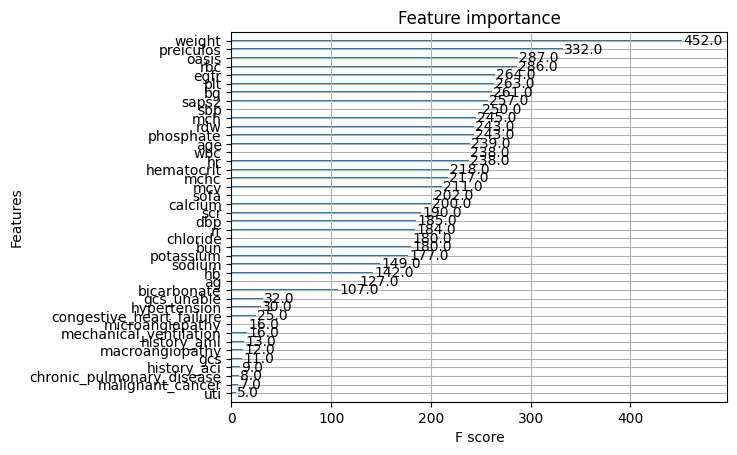

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

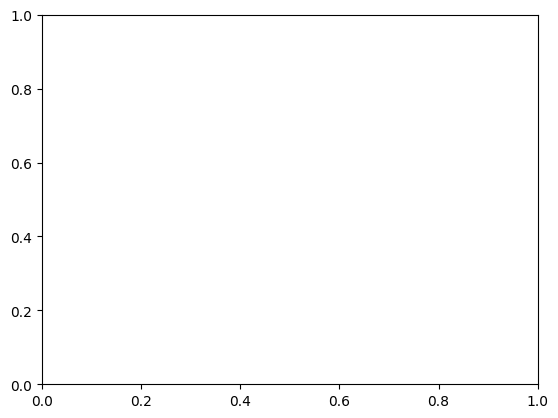

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66603


[1]	validation_0-logloss:0.66293


[2]	validation_0-logloss:0.66091


[3]	validation_0-logloss:0.65864


[4]	validation_0-logloss:0.65651


[5]	validation_0-logloss:0.65405


[6]	validation_0-logloss:0.65232


[7]	validation_0-logloss:0.64977


[8]	validation_0-logloss:0.64707


[9]	validation_0-logloss:0.64540


[10]	validation_0-logloss:0.64344


[11]	validation_0-logloss:0.64145


[12]	validation_0-logloss:0.63982


[13]	validation_0-logloss:0.63805


[14]	validation_0-logloss:0.63622


[15]	validation_0-logloss:0.63405


[16]	validation_0-logloss:0.63219


[17]	validation_0-logloss:0.63058


[18]	validation_0-logloss:0.62934


[19]	validation_0-logloss:0.62781


[20]	validation_0-logloss:0.62634


[21]	validation_0-logloss:0.62479


[22]	validation_0-logloss:0.62309


[23]	validation_0-logloss:0.62135


[24]	validation_0-logloss:0.61973


[25]	validation_0-logloss:0.61765


[26]	validation_0-logloss:0.61612


[27]	validation_0-logloss:0.61496


[28]	validation_0-logloss:0.61287


[29]	validation_0-logloss:0.61093


[30]	validation_0-logloss:0.60944


[31]	validation_0-logloss:0.60836


[32]	validation_0-logloss:0.60682


[33]	validation_0-logloss:0.60612


[34]	validation_0-logloss:0.60451


[35]	validation_0-logloss:0.60274


[36]	validation_0-logloss:0.60132


[37]	validation_0-logloss:0.60009


[38]	validation_0-logloss:0.59854


[39]	validation_0-logloss:0.59736


[40]	validation_0-logloss:0.59593


[41]	validation_0-logloss:0.59446


[42]	validation_0-logloss:0.59337


[43]	validation_0-logloss:0.59217


[44]	validation_0-logloss:0.59095


[45]	validation_0-logloss:0.58973


[46]	validation_0-logloss:0.58852


[47]	validation_0-logloss:0.58723


[48]	validation_0-logloss:0.58580


[49]	validation_0-logloss:0.58475


[50]	validation_0-logloss:0.58365


[51]	validation_0-logloss:0.58240


[52]	validation_0-logloss:0.58155


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:04:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[53]	validation_0-logloss:0.58019


[54]	validation_0-logloss:0.57906


[55]	validation_0-logloss:0.57794


[56]	validation_0-logloss:0.57707


[57]	validation_0-logloss:0.57571


[58]	validation_0-logloss:0.57510


[59]	validation_0-logloss:0.57426


[60]	validation_0-logloss:0.57321


[61]	validation_0-logloss:0.57224


[62]	validation_0-logloss:0.57060


[63]	validation_0-logloss:0.56934


[64]	validation_0-logloss:0.56840


[65]	validation_0-logloss:0.56733


[66]	validation_0-logloss:0.56611


[67]	validation_0-logloss:0.56524


[68]	validation_0-logloss:0.56434


[69]	validation_0-logloss:0.56392


[70]	validation_0-logloss:0.56330


[71]	validation_0-logloss:0.56248


[72]	validation_0-logloss:0.56176


[73]	validation_0-logloss:0.56061


[74]	validation_0-logloss:0.55974


[75]	validation_0-logloss:0.55927


[76]	validation_0-logloss:0.55890


[77]	validation_0-logloss:0.55795


[78]	validation_0-logloss:0.55733


[79]	validation_0-logloss:0.55672


[80]	validation_0-logloss:0.55559


[81]	validation_0-logloss:0.55475


[82]	validation_0-logloss:0.55426


[83]	validation_0-logloss:0.55357


[84]	validation_0-logloss:0.55215


[85]	validation_0-logloss:0.55168


[86]	validation_0-logloss:0.55100


[87]	validation_0-logloss:0.55041


[88]	validation_0-logloss:0.54950


[89]	validation_0-logloss:0.54908


[90]	validation_0-logloss:0.54819


[91]	validation_0-logloss:0.54803


[92]	validation_0-logloss:0.54729


[93]	validation_0-logloss:0.54657


[94]	validation_0-logloss:0.54623


[95]	validation_0-logloss:0.54559


[96]	validation_0-logloss:0.54507


[97]	validation_0-logloss:0.54488


[98]	validation_0-logloss:0.54437


[99]	validation_0-logloss:0.54379


[100]	validation_0-logloss:0.54328


[101]	validation_0-logloss:0.54264


[102]	validation_0-logloss:0.54211


[103]	validation_0-logloss:0.54149


[104]	validation_0-logloss:0.54123


[105]	validation_0-logloss:0.54046


[106]	validation_0-logloss:0.53978


[107]	validation_0-logloss:0.53924


[108]	validation_0-logloss:0.53868


[109]	validation_0-logloss:0.53790


[110]	validation_0-logloss:0.53767


[111]	validation_0-logloss:0.53743


[112]	validation_0-logloss:0.53688


[113]	validation_0-logloss:0.53660


[114]	validation_0-logloss:0.53612


[115]	validation_0-logloss:0.53573


[116]	validation_0-logloss:0.53541


[117]	validation_0-logloss:0.53489


[118]	validation_0-logloss:0.53426


[119]	validation_0-logloss:0.53379


[120]	validation_0-logloss:0.53324


[121]	validation_0-logloss:0.53282


[122]	validation_0-logloss:0.53232


[123]	validation_0-logloss:0.53211


[124]	validation_0-logloss:0.53135


[125]	validation_0-logloss:0.53076


[126]	validation_0-logloss:0.53019


[127]	validation_0-logloss:0.52983


[128]	validation_0-logloss:0.52958


[129]	validation_0-logloss:0.52916


[130]	validation_0-logloss:0.52861


[131]	validation_0-logloss:0.52855


[132]	validation_0-logloss:0.52804


[133]	validation_0-logloss:0.52753


[134]	validation_0-logloss:0.52777


[135]	validation_0-logloss:0.52755


[136]	validation_0-logloss:0.52703


[137]	validation_0-logloss:0.52660


[138]	validation_0-logloss:0.52643


[139]	validation_0-logloss:0.52615


[140]	validation_0-logloss:0.52592


[141]	validation_0-logloss:0.52592


[142]	validation_0-logloss:0.52594


[143]	validation_0-logloss:0.52556


[144]	validation_0-logloss:0.52541


[145]	validation_0-logloss:0.52546


[146]	validation_0-logloss:0.52489


[147]	validation_0-logloss:0.52445


[148]	validation_0-logloss:0.52416


[149]	validation_0-logloss:0.52410


[150]	validation_0-logloss:0.52390


[151]	validation_0-logloss:0.52341


[152]	validation_0-logloss:0.52309


[153]	validation_0-logloss:0.52283


[154]	validation_0-logloss:0.52257


[155]	validation_0-logloss:0.52245


[156]	validation_0-logloss:0.52219


[157]	validation_0-logloss:0.52192


[158]	validation_0-logloss:0.52171


[159]	validation_0-logloss:0.52149


[160]	validation_0-logloss:0.52138


[161]	validation_0-logloss:0.52092


[162]	validation_0-logloss:0.52100


[163]	validation_0-logloss:0.52052


[164]	validation_0-logloss:0.52012


[165]	validation_0-logloss:0.52002


[166]	validation_0-logloss:0.51983


[167]	validation_0-logloss:0.51981


[168]	validation_0-logloss:0.51944


[169]	validation_0-logloss:0.51963


[170]	validation_0-logloss:0.51933


[171]	validation_0-logloss:0.51892


[172]	validation_0-logloss:0.51873


[173]	validation_0-logloss:0.51867


[174]	validation_0-logloss:0.51837


[175]	validation_0-logloss:0.51855


[176]	validation_0-logloss:0.51851


[177]	validation_0-logloss:0.51833


[178]	validation_0-logloss:0.51805


[179]	validation_0-logloss:0.51798


[180]	validation_0-logloss:0.51792


[181]	validation_0-logloss:0.51767


[182]	validation_0-logloss:0.51696


[183]	validation_0-logloss:0.51686


[184]	validation_0-logloss:0.51650


[185]	validation_0-logloss:0.51657


[186]	validation_0-logloss:0.51635


[187]	validation_0-logloss:0.51618


[188]	validation_0-logloss:0.51565


[189]	validation_0-logloss:0.51555


[190]	validation_0-logloss:0.51533


[191]	validation_0-logloss:0.51526


[192]	validation_0-logloss:0.51539


[193]	validation_0-logloss:0.51508


[194]	validation_0-logloss:0.51518


[195]	validation_0-logloss:0.51489


[196]	validation_0-logloss:0.51475


[197]	validation_0-logloss:0.51438


[198]	validation_0-logloss:0.51433


[199]	validation_0-logloss:0.51408


[200]	validation_0-logloss:0.51396


[201]	validation_0-logloss:0.51391


[202]	validation_0-logloss:0.51365


[203]	validation_0-logloss:0.51370


[204]	validation_0-logloss:0.51335


[205]	validation_0-logloss:0.51350


[206]	validation_0-logloss:0.51340


[207]	validation_0-logloss:0.51327


[208]	validation_0-logloss:0.51339


[209]	validation_0-logloss:0.51364


[210]	validation_0-logloss:0.51326


[211]	validation_0-logloss:0.51305


[212]	validation_0-logloss:0.51295


[213]	validation_0-logloss:0.51256


[214]	validation_0-logloss:0.51240


[215]	validation_0-logloss:0.51219


[216]	validation_0-logloss:0.51212


[217]	validation_0-logloss:0.51191


[218]	validation_0-logloss:0.51178


[219]	validation_0-logloss:0.51182


[220]	validation_0-logloss:0.51158


[221]	validation_0-logloss:0.51147


[222]	validation_0-logloss:0.51118


[223]	validation_0-logloss:0.51092


[224]	validation_0-logloss:0.51085


[225]	validation_0-logloss:0.51056


[226]	validation_0-logloss:0.51031


[227]	validation_0-logloss:0.51033


[228]	validation_0-logloss:0.50997


[229]	validation_0-logloss:0.51000


[230]	validation_0-logloss:0.50987


[231]	validation_0-logloss:0.50987


[232]	validation_0-logloss:0.51011


[233]	validation_0-logloss:0.50991


[234]	validation_0-logloss:0.50970


[235]	validation_0-logloss:0.50953


[236]	validation_0-logloss:0.50960


[237]	validation_0-logloss:0.50936


[238]	validation_0-logloss:0.50901


[239]	validation_0-logloss:0.50897


[240]	validation_0-logloss:0.50870


[241]	validation_0-logloss:0.50852


[242]	validation_0-logloss:0.50838


[243]	validation_0-logloss:0.50835


[244]	validation_0-logloss:0.50837


[245]	validation_0-logloss:0.50848


[246]	validation_0-logloss:0.50833


[247]	validation_0-logloss:0.50831


[248]	validation_0-logloss:0.50826


[249]	validation_0-logloss:0.50821


[250]	validation_0-logloss:0.50787


[251]	validation_0-logloss:0.50762


[252]	validation_0-logloss:0.50798


[253]	validation_0-logloss:0.50793


[254]	validation_0-logloss:0.50768


[255]	validation_0-logloss:0.50773


[256]	validation_0-logloss:0.50759


[257]	validation_0-logloss:0.50749


[258]	validation_0-logloss:0.50718


[259]	validation_0-logloss:0.50689


[260]	validation_0-logloss:0.50700


[261]	validation_0-logloss:0.50709


[262]	validation_0-logloss:0.50692


[263]	validation_0-logloss:0.50654


[264]	validation_0-logloss:0.50670


[265]	validation_0-logloss:0.50656


[266]	validation_0-logloss:0.50658


[267]	validation_0-logloss:0.50672


[268]	validation_0-logloss:0.50647


[269]	validation_0-logloss:0.50638


[270]	validation_0-logloss:0.50637


[271]	validation_0-logloss:0.50660


[272]	validation_0-logloss:0.50636


[273]	validation_0-logloss:0.50639


[274]	validation_0-logloss:0.50658


[275]	validation_0-logloss:0.50649


[276]	validation_0-logloss:0.50630


[277]	validation_0-logloss:0.50606


[278]	validation_0-logloss:0.50634


[279]	validation_0-logloss:0.50610


[280]	validation_0-logloss:0.50617


[281]	validation_0-logloss:0.50606


[282]	validation_0-logloss:0.50633


[283]	validation_0-logloss:0.50618


[284]	validation_0-logloss:0.50636


[285]	validation_0-logloss:0.50650


[286]	validation_0-logloss:0.50647


[287]	validation_0-logloss:0.50643


[0]	validation_0-logloss:0.66755


[1]	validation_0-logloss:0.66526


[2]	validation_0-logloss:0.66245


[3]	validation_0-logloss:0.66038


[4]	validation_0-logloss:0.65820


[5]	validation_0-logloss:0.65591


[6]	validation_0-logloss:0.65479


[7]	validation_0-logloss:0.65293


[8]	validation_0-logloss:0.65090


[9]	validation_0-logloss:0.64925


[10]	validation_0-logloss:0.64781


[11]	validation_0-logloss:0.64544


[12]	validation_0-logloss:0.64423


[13]	validation_0-logloss:0.64188


[14]	validation_0-logloss:0.64033


[15]	validation_0-logloss:0.63871


[16]	validation_0-logloss:0.63702


[17]	validation_0-logloss:0.63520


[18]	validation_0-logloss:0.63362


[19]	validation_0-logloss:0.63179


[20]	validation_0-logloss:0.63009


[21]	validation_0-logloss:0.62817


[22]	validation_0-logloss:0.62645


[23]	validation_0-logloss:0.62521


[24]	validation_0-logloss:0.62327


[25]	validation_0-logloss:0.62164


[26]	validation_0-logloss:0.62005


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:04:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-logloss:0.61901


[28]	validation_0-logloss:0.61796


[29]	validation_0-logloss:0.61661


[30]	validation_0-logloss:0.61537


[31]	validation_0-logloss:0.61410


[32]	validation_0-logloss:0.61336


[33]	validation_0-logloss:0.61183


[34]	validation_0-logloss:0.61031


[35]	validation_0-logloss:0.60860


[36]	validation_0-logloss:0.60676


[37]	validation_0-logloss:0.60539


[38]	validation_0-logloss:0.60356


[39]	validation_0-logloss:0.60162


[40]	validation_0-logloss:0.60044


[41]	validation_0-logloss:0.59917


[42]	validation_0-logloss:0.59789


[43]	validation_0-logloss:0.59727


[44]	validation_0-logloss:0.59606


[45]	validation_0-logloss:0.59502


[46]	validation_0-logloss:0.59390


[47]	validation_0-logloss:0.59312


[48]	validation_0-logloss:0.59197


[49]	validation_0-logloss:0.59126


[50]	validation_0-logloss:0.59034


[51]	validation_0-logloss:0.58904


[52]	validation_0-logloss:0.58814


[53]	validation_0-logloss:0.58757


[54]	validation_0-logloss:0.58660


[55]	validation_0-logloss:0.58564


[56]	validation_0-logloss:0.58454


[57]	validation_0-logloss:0.58319


[58]	validation_0-logloss:0.58245


[59]	validation_0-logloss:0.58210


[60]	validation_0-logloss:0.58142


[61]	validation_0-logloss:0.58058


[62]	validation_0-logloss:0.57953


[63]	validation_0-logloss:0.57852


[64]	validation_0-logloss:0.57738


[65]	validation_0-logloss:0.57646


[66]	validation_0-logloss:0.57546


[67]	validation_0-logloss:0.57465


[68]	validation_0-logloss:0.57342


[69]	validation_0-logloss:0.57276


[70]	validation_0-logloss:0.57190


[71]	validation_0-logloss:0.57125


[72]	validation_0-logloss:0.57062


[73]	validation_0-logloss:0.56971


[74]	validation_0-logloss:0.56903


[75]	validation_0-logloss:0.56835


[76]	validation_0-logloss:0.56741


[77]	validation_0-logloss:0.56709


[78]	validation_0-logloss:0.56597


[79]	validation_0-logloss:0.56477


[80]	validation_0-logloss:0.56414


[81]	validation_0-logloss:0.56302


[82]	validation_0-logloss:0.56217


[83]	validation_0-logloss:0.56159


[84]	validation_0-logloss:0.56035


[85]	validation_0-logloss:0.55983


[86]	validation_0-logloss:0.55891


[87]	validation_0-logloss:0.55823


[88]	validation_0-logloss:0.55732


[89]	validation_0-logloss:0.55648


[90]	validation_0-logloss:0.55581


[91]	validation_0-logloss:0.55505


[92]	validation_0-logloss:0.55446


[93]	validation_0-logloss:0.55344


[94]	validation_0-logloss:0.55262


[95]	validation_0-logloss:0.55187


[96]	validation_0-logloss:0.55141


[97]	validation_0-logloss:0.55041


[98]	validation_0-logloss:0.54996


[99]	validation_0-logloss:0.54942


[100]	validation_0-logloss:0.54883


[101]	validation_0-logloss:0.54769


[102]	validation_0-logloss:0.54713


[103]	validation_0-logloss:0.54638


[104]	validation_0-logloss:0.54591


[105]	validation_0-logloss:0.54528


[106]	validation_0-logloss:0.54511


[107]	validation_0-logloss:0.54460


[108]	validation_0-logloss:0.54419


[109]	validation_0-logloss:0.54343


[110]	validation_0-logloss:0.54318


[111]	validation_0-logloss:0.54235


[112]	validation_0-logloss:0.54185


[113]	validation_0-logloss:0.54191


[114]	validation_0-logloss:0.54145


[115]	validation_0-logloss:0.54112


[116]	validation_0-logloss:0.54100


[117]	validation_0-logloss:0.54030


[118]	validation_0-logloss:0.53965


[119]	validation_0-logloss:0.53906


[120]	validation_0-logloss:0.53846


[121]	validation_0-logloss:0.53800


[122]	validation_0-logloss:0.53774


[123]	validation_0-logloss:0.53738


[124]	validation_0-logloss:0.53686


[125]	validation_0-logloss:0.53630


[126]	validation_0-logloss:0.53580


[127]	validation_0-logloss:0.53522


[128]	validation_0-logloss:0.53490


[129]	validation_0-logloss:0.53437


[130]	validation_0-logloss:0.53399


[131]	validation_0-logloss:0.53368


[132]	validation_0-logloss:0.53355


[133]	validation_0-logloss:0.53340


[134]	validation_0-logloss:0.53291


[135]	validation_0-logloss:0.53262


[136]	validation_0-logloss:0.53218


[137]	validation_0-logloss:0.53211


[138]	validation_0-logloss:0.53234


[139]	validation_0-logloss:0.53152


[140]	validation_0-logloss:0.53140


[141]	validation_0-logloss:0.53110


[142]	validation_0-logloss:0.53092


[143]	validation_0-logloss:0.53025


[144]	validation_0-logloss:0.52994


[145]	validation_0-logloss:0.52963


[146]	validation_0-logloss:0.52960


[147]	validation_0-logloss:0.52928


[148]	validation_0-logloss:0.52886


[149]	validation_0-logloss:0.52883


[150]	validation_0-logloss:0.52861


[151]	validation_0-logloss:0.52832


[152]	validation_0-logloss:0.52807


[153]	validation_0-logloss:0.52807


[154]	validation_0-logloss:0.52779


[155]	validation_0-logloss:0.52767


[156]	validation_0-logloss:0.52744


[157]	validation_0-logloss:0.52745


[158]	validation_0-logloss:0.52696


[159]	validation_0-logloss:0.52666


[160]	validation_0-logloss:0.52652


[161]	validation_0-logloss:0.52638


[162]	validation_0-logloss:0.52612


[163]	validation_0-logloss:0.52625


[164]	validation_0-logloss:0.52617


[165]	validation_0-logloss:0.52589


[166]	validation_0-logloss:0.52547


[167]	validation_0-logloss:0.52519


[168]	validation_0-logloss:0.52529


[169]	validation_0-logloss:0.52502


[170]	validation_0-logloss:0.52507


[171]	validation_0-logloss:0.52488


[172]	validation_0-logloss:0.52450


[173]	validation_0-logloss:0.52385


[174]	validation_0-logloss:0.52376


[175]	validation_0-logloss:0.52361


[176]	validation_0-logloss:0.52359


[177]	validation_0-logloss:0.52344


[178]	validation_0-logloss:0.52299


[179]	validation_0-logloss:0.52267


[180]	validation_0-logloss:0.52276


[181]	validation_0-logloss:0.52250


[182]	validation_0-logloss:0.52200


[183]	validation_0-logloss:0.52164


[184]	validation_0-logloss:0.52150


[185]	validation_0-logloss:0.52146


[186]	validation_0-logloss:0.52122


[187]	validation_0-logloss:0.52094


[188]	validation_0-logloss:0.52094


[189]	validation_0-logloss:0.52088


[190]	validation_0-logloss:0.52043


[191]	validation_0-logloss:0.52018


[192]	validation_0-logloss:0.51967


[193]	validation_0-logloss:0.51948


[194]	validation_0-logloss:0.51908


[195]	validation_0-logloss:0.51897


[196]	validation_0-logloss:0.51916


[197]	validation_0-logloss:0.51899


[198]	validation_0-logloss:0.51878


[199]	validation_0-logloss:0.51858


[200]	validation_0-logloss:0.51873


[201]	validation_0-logloss:0.51858


[202]	validation_0-logloss:0.51860


[203]	validation_0-logloss:0.51888


[204]	validation_0-logloss:0.51881


[205]	validation_0-logloss:0.51861


[206]	validation_0-logloss:0.51842


[207]	validation_0-logloss:0.51827


[208]	validation_0-logloss:0.51809


[209]	validation_0-logloss:0.51760


[210]	validation_0-logloss:0.51774


[211]	validation_0-logloss:0.51756


[212]	validation_0-logloss:0.51780


[213]	validation_0-logloss:0.51758


[214]	validation_0-logloss:0.51745


[215]	validation_0-logloss:0.51740


[216]	validation_0-logloss:0.51712


[217]	validation_0-logloss:0.51697


[218]	validation_0-logloss:0.51695


[219]	validation_0-logloss:0.51683


[220]	validation_0-logloss:0.51665


[221]	validation_0-logloss:0.51660


[222]	validation_0-logloss:0.51669


[223]	validation_0-logloss:0.51635


[224]	validation_0-logloss:0.51620


[225]	validation_0-logloss:0.51611


[226]	validation_0-logloss:0.51592


[227]	validation_0-logloss:0.51580


[228]	validation_0-logloss:0.51570


[229]	validation_0-logloss:0.51530


[230]	validation_0-logloss:0.51503


[231]	validation_0-logloss:0.51498


[232]	validation_0-logloss:0.51500


[233]	validation_0-logloss:0.51478


[234]	validation_0-logloss:0.51451


[235]	validation_0-logloss:0.51437


[236]	validation_0-logloss:0.51417


[237]	validation_0-logloss:0.51401


[238]	validation_0-logloss:0.51416


[239]	validation_0-logloss:0.51369


[240]	validation_0-logloss:0.51383


[241]	validation_0-logloss:0.51376


[242]	validation_0-logloss:0.51374


[243]	validation_0-logloss:0.51349


[244]	validation_0-logloss:0.51310


[245]	validation_0-logloss:0.51321


[246]	validation_0-logloss:0.51315


[247]	validation_0-logloss:0.51289


[248]	validation_0-logloss:0.51279


[249]	validation_0-logloss:0.51278


[250]	validation_0-logloss:0.51275


[251]	validation_0-logloss:0.51271


[252]	validation_0-logloss:0.51265


[253]	validation_0-logloss:0.51272


[254]	validation_0-logloss:0.51265


[255]	validation_0-logloss:0.51256


[256]	validation_0-logloss:0.51236


[257]	validation_0-logloss:0.51229


[258]	validation_0-logloss:0.51232


[259]	validation_0-logloss:0.51230


[260]	validation_0-logloss:0.51233


[261]	validation_0-logloss:0.51235


[262]	validation_0-logloss:0.51239


[263]	validation_0-logloss:0.51240


[264]	validation_0-logloss:0.51237


[265]	validation_0-logloss:0.51217


[266]	validation_0-logloss:0.51232


[267]	validation_0-logloss:0.51203


[268]	validation_0-logloss:0.51243


[269]	validation_0-logloss:0.51236


[270]	validation_0-logloss:0.51248


[271]	validation_0-logloss:0.51241


[272]	validation_0-logloss:0.51248


[273]	validation_0-logloss:0.51236


[274]	validation_0-logloss:0.51214


[275]	validation_0-logloss:0.51212


[276]	validation_0-logloss:0.51233


[277]	validation_0-logloss:0.51196


[278]	validation_0-logloss:0.51195


[279]	validation_0-logloss:0.51216


[280]	validation_0-logloss:0.51209


[281]	validation_0-logloss:0.51233


[282]	validation_0-logloss:0.51243


[283]	validation_0-logloss:0.51255


[284]	validation_0-logloss:0.51283


[285]	validation_0-logloss:0.51296


[286]	validation_0-logloss:0.51301


[287]	validation_0-logloss:0.51297


[0]	validation_0-logloss:0.66810


[1]	validation_0-logloss:0.66593


[2]	validation_0-logloss:0.66399


[3]	validation_0-logloss:0.66237


[4]	validation_0-logloss:0.66007


[5]	validation_0-logloss:0.65908


[6]	validation_0-logloss:0.65799


[7]	validation_0-logloss:0.65629


[8]	validation_0-logloss:0.65475


[9]	validation_0-logloss:0.65268


[10]	validation_0-logloss:0.65163


[11]	validation_0-logloss:0.64988


[12]	validation_0-logloss:0.64831


[13]	validation_0-logloss:0.64684


[14]	validation_0-logloss:0.64494


[15]	validation_0-logloss:0.64320


[16]	validation_0-logloss:0.64240


[17]	validation_0-logloss:0.64070


[18]	validation_0-logloss:0.63941


[19]	validation_0-logloss:0.63821


[20]	validation_0-logloss:0.63658


[21]	validation_0-logloss:0.63515


[22]	validation_0-logloss:0.63384


[23]	validation_0-logloss:0.63240


[24]	validation_0-logloss:0.63087


[25]	validation_0-logloss:0.62947


[26]	validation_0-logloss:0.62824


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:04:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-logloss:0.62719


[28]	validation_0-logloss:0.62606


[29]	validation_0-logloss:0.62530


[30]	validation_0-logloss:0.62430


[31]	validation_0-logloss:0.62344


[32]	validation_0-logloss:0.62244


[33]	validation_0-logloss:0.62155


[34]	validation_0-logloss:0.62128


[35]	validation_0-logloss:0.61942


[36]	validation_0-logloss:0.61783


[37]	validation_0-logloss:0.61704


[38]	validation_0-logloss:0.61634


[39]	validation_0-logloss:0.61476


[40]	validation_0-logloss:0.61388


[41]	validation_0-logloss:0.61337


[42]	validation_0-logloss:0.61302


[43]	validation_0-logloss:0.61182


[44]	validation_0-logloss:0.61086


[45]	validation_0-logloss:0.61007


[46]	validation_0-logloss:0.60898


[47]	validation_0-logloss:0.60733


[48]	validation_0-logloss:0.60641


[49]	validation_0-logloss:0.60533


[50]	validation_0-logloss:0.60457


[51]	validation_0-logloss:0.60357


[52]	validation_0-logloss:0.60310


[53]	validation_0-logloss:0.60199


[54]	validation_0-logloss:0.60115


[55]	validation_0-logloss:0.60036


[56]	validation_0-logloss:0.59956


[57]	validation_0-logloss:0.59904


[58]	validation_0-logloss:0.59875


[59]	validation_0-logloss:0.59775


[60]	validation_0-logloss:0.59732


[61]	validation_0-logloss:0.59620


[62]	validation_0-logloss:0.59534


[63]	validation_0-logloss:0.59412


[64]	validation_0-logloss:0.59356


[65]	validation_0-logloss:0.59303


[66]	validation_0-logloss:0.59224


[67]	validation_0-logloss:0.59182


[68]	validation_0-logloss:0.59169


[69]	validation_0-logloss:0.59128


[70]	validation_0-logloss:0.59090


[71]	validation_0-logloss:0.59053


[72]	validation_0-logloss:0.58996


[73]	validation_0-logloss:0.58900


[74]	validation_0-logloss:0.58820


[75]	validation_0-logloss:0.58749


[76]	validation_0-logloss:0.58695


[77]	validation_0-logloss:0.58653


[78]	validation_0-logloss:0.58588


[79]	validation_0-logloss:0.58572


[80]	validation_0-logloss:0.58532


[81]	validation_0-logloss:0.58492


[82]	validation_0-logloss:0.58420


[83]	validation_0-logloss:0.58346


[84]	validation_0-logloss:0.58280


[85]	validation_0-logloss:0.58253


[86]	validation_0-logloss:0.58173


[87]	validation_0-logloss:0.58138


[88]	validation_0-logloss:0.58054


[89]	validation_0-logloss:0.58044


[90]	validation_0-logloss:0.58005

[91]	validation_0-logloss:0.57992


[92]	validation_0-logloss:0.57958


[93]	validation_0-logloss:0.57921


[94]	validation_0-logloss:0.57875


[95]	validation_0-logloss:0.57830


[96]	validation_0-logloss:0.57794


[97]	validation_0-logloss:0.57787


[98]	validation_0-logloss:0.57710


[99]	validation_0-logloss:0.57666


[100]	validation_0-logloss:0.57676


[101]	validation_0-logloss:0.57629


[102]	validation_0-logloss:0.57630


[103]	validation_0-logloss:0.57603


[104]	validation_0-logloss:0.57537


[105]	validation_0-logloss:0.57501


[106]	validation_0-logloss:0.57469


[107]	validation_0-logloss:0.57457


[108]	validation_0-logloss:0.57435


[109]	validation_0-logloss:0.57413


[110]	validation_0-logloss:0.57379


[111]	validation_0-logloss:0.57358


[112]	validation_0-logloss:0.57321


[113]	validation_0-logloss:0.57279


[114]	validation_0-logloss:0.57277


[115]	validation_0-logloss:0.57213


[116]	validation_0-logloss:0.57179


[117]	validation_0-logloss:0.57157


[118]	validation_0-logloss:0.57124


[119]	validation_0-logloss:0.57093


[120]	validation_0-logloss:0.57098


[121]	validation_0-logloss:0.57091


[122]	validation_0-logloss:0.57071


[123]	validation_0-logloss:0.57016


[124]	validation_0-logloss:0.57034


[125]	validation_0-logloss:0.57021


[126]	validation_0-logloss:0.57032


[127]	validation_0-logloss:0.57011


[128]	validation_0-logloss:0.56957


[129]	validation_0-logloss:0.56952


[130]	validation_0-logloss:0.56947


[131]	validation_0-logloss:0.56944


[132]	validation_0-logloss:0.56917


[133]	validation_0-logloss:0.56904


[134]	validation_0-logloss:0.56883


[135]	validation_0-logloss:0.56870


[136]	validation_0-logloss:0.56833


[137]	validation_0-logloss:0.56804


[138]	validation_0-logloss:0.56769


[139]	validation_0-logloss:0.56743


[140]	validation_0-logloss:0.56715


[141]	validation_0-logloss:0.56689


[142]	validation_0-logloss:0.56672


[143]	validation_0-logloss:0.56660


[144]	validation_0-logloss:0.56650


[145]	validation_0-logloss:0.56618


[146]	validation_0-logloss:0.56561


[147]	validation_0-logloss:0.56564


[148]	validation_0-logloss:0.56547


[149]	validation_0-logloss:0.56526


[150]	validation_0-logloss:0.56508


[151]	validation_0-logloss:0.56501


[152]	validation_0-logloss:0.56429


[153]	validation_0-logloss:0.56434


[154]	validation_0-logloss:0.56426


[155]	validation_0-logloss:0.56372


[156]	validation_0-logloss:0.56366


[157]	validation_0-logloss:0.56333


[158]	validation_0-logloss:0.56307


[159]	validation_0-logloss:0.56279


[160]	validation_0-logloss:0.56267


[161]	validation_0-logloss:0.56309


[162]	validation_0-logloss:0.56289


[163]	validation_0-logloss:0.56289


[164]	validation_0-logloss:0.56273


[165]	validation_0-logloss:0.56291


[166]	validation_0-logloss:0.56302


[167]	validation_0-logloss:0.56285


[168]	validation_0-logloss:0.56297


[169]	validation_0-logloss:0.56289


[0]	validation_0-logloss:0.66761


[1]	validation_0-logloss:0.66610


[2]	validation_0-logloss:0.66348


[3]	validation_0-logloss:0.66158


[4]	validation_0-logloss:0.65912


[5]	validation_0-logloss:0.65667


[6]	validation_0-logloss:0.65480


[7]	validation_0-logloss:0.65292


[8]	validation_0-logloss:0.65104


[9]	validation_0-logloss:0.64927


[10]	validation_0-logloss:0.64698


[11]	validation_0-logloss:0.64540


[12]	validation_0-logloss:0.64414


[13]	validation_0-logloss:0.64259


[14]	validation_0-logloss:0.64117


[15]	validation_0-logloss:0.63987


[16]	validation_0-logloss:0.63784


[17]	validation_0-logloss:0.63593


[18]	validation_0-logloss:0.63459


[19]	validation_0-logloss:0.63343


[20]	validation_0-logloss:0.63219


[21]	validation_0-logloss:0.63058


[22]	validation_0-logloss:0.62884


[23]	validation_0-logloss:0.62759


[24]	validation_0-logloss:0.62567


[25]	validation_0-logloss:0.62382


[26]	validation_0-logloss:0.62230


[27]	validation_0-logloss:0.62088


[28]	validation_0-logloss:0.61917


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:04:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-logloss:0.61755


[30]	validation_0-logloss:0.61621


[31]	validation_0-logloss:0.61518


[32]	validation_0-logloss:0.61388


[33]	validation_0-logloss:0.61260


[34]	validation_0-logloss:0.61126


[35]	validation_0-logloss:0.60946


[36]	validation_0-logloss:0.60825


[37]	validation_0-logloss:0.60764


[38]	validation_0-logloss:0.60675


[39]	validation_0-logloss:0.60546


[40]	validation_0-logloss:0.60460


[41]	validation_0-logloss:0.60402


[42]	validation_0-logloss:0.60268


[43]	validation_0-logloss:0.60157


[44]	validation_0-logloss:0.60118


[45]	validation_0-logloss:0.60013


[46]	validation_0-logloss:0.59880


[47]	validation_0-logloss:0.59753


[48]	validation_0-logloss:0.59659


[49]	validation_0-logloss:0.59626


[50]	validation_0-logloss:0.59540


[51]	validation_0-logloss:0.59458


[52]	validation_0-logloss:0.59373


[53]	validation_0-logloss:0.59318


[54]	validation_0-logloss:0.59249


[55]	validation_0-logloss:0.59129


[56]	validation_0-logloss:0.59002


[57]	validation_0-logloss:0.58927


[58]	validation_0-logloss:0.58831


[59]	validation_0-logloss:0.58781


[60]	validation_0-logloss:0.58663


[61]	validation_0-logloss:0.58574


[62]	validation_0-logloss:0.58469


[63]	validation_0-logloss:0.58378


[64]	validation_0-logloss:0.58364


[65]	validation_0-logloss:0.58264


[66]	validation_0-logloss:0.58191


[67]	validation_0-logloss:0.58133


[68]	validation_0-logloss:0.58045


[69]	validation_0-logloss:0.57997


[70]	validation_0-logloss:0.57891


[71]	validation_0-logloss:0.57850


[72]	validation_0-logloss:0.57771


[73]	validation_0-logloss:0.57718


[74]	validation_0-logloss:0.57662


[75]	validation_0-logloss:0.57585


[76]	validation_0-logloss:0.57510


[77]	validation_0-logloss:0.57453


[78]	validation_0-logloss:0.57387


[79]	validation_0-logloss:0.57336


[80]	validation_0-logloss:0.57295


[81]	validation_0-logloss:0.57248


[82]	validation_0-logloss:0.57172


[83]	validation_0-logloss:0.57152


[84]	validation_0-logloss:0.57069


[85]	validation_0-logloss:0.56996


[86]	validation_0-logloss:0.56932


[87]	validation_0-logloss:0.56884


[88]	validation_0-logloss:0.56812


[89]	validation_0-logloss:0.56746


[90]	validation_0-logloss:0.56676


[91]	validation_0-logloss:0.56636


[92]	validation_0-logloss:0.56599


[93]	validation_0-logloss:0.56524


[94]	validation_0-logloss:0.56483


[95]	validation_0-logloss:0.56450


[96]	validation_0-logloss:0.56385


[97]	validation_0-logloss:0.56310


[98]	validation_0-logloss:0.56274


[99]	validation_0-logloss:0.56237


[100]	validation_0-logloss:0.56216


[101]	validation_0-logloss:0.56133


[102]	validation_0-logloss:0.56062


[103]	validation_0-logloss:0.56043


[104]	validation_0-logloss:0.55965


[105]	validation_0-logloss:0.55956


[106]	validation_0-logloss:0.55904


[107]	validation_0-logloss:0.55839


[108]	validation_0-logloss:0.55745


[109]	validation_0-logloss:0.55719


[110]	validation_0-logloss:0.55696


[111]	validation_0-logloss:0.55663


[112]	validation_0-logloss:0.55608


[113]	validation_0-logloss:0.55565


[114]	validation_0-logloss:0.55504


[115]	validation_0-logloss:0.55454


[116]	validation_0-logloss:0.55411


[117]	validation_0-logloss:0.55384


[118]	validation_0-logloss:0.55322


[119]	validation_0-logloss:0.55248


[120]	validation_0-logloss:0.55181


[121]	validation_0-logloss:0.55131


[122]	validation_0-logloss:0.55082


[123]	validation_0-logloss:0.55056


[124]	validation_0-logloss:0.55002


[125]	validation_0-logloss:0.55000


[126]	validation_0-logloss:0.54987


[127]	validation_0-logloss:0.54979


[128]	validation_0-logloss:0.54984


[129]	validation_0-logloss:0.54961


[130]	validation_0-logloss:0.54938


[131]	validation_0-logloss:0.54972


[132]	validation_0-logloss:0.54986


[133]	validation_0-logloss:0.54997


[134]	validation_0-logloss:0.54991


[135]	validation_0-logloss:0.54942


[136]	validation_0-logloss:0.54942


[137]	validation_0-logloss:0.54913


[138]	validation_0-logloss:0.54902


[139]	validation_0-logloss:0.54918


[140]	validation_0-logloss:0.54889


[141]	validation_0-logloss:0.54831


[142]	validation_0-logloss:0.54828


[143]	validation_0-logloss:0.54833


[144]	validation_0-logloss:0.54806


[145]	validation_0-logloss:0.54756


[146]	validation_0-logloss:0.54715


[147]	validation_0-logloss:0.54697


[148]	validation_0-logloss:0.54658


[149]	validation_0-logloss:0.54689


[150]	validation_0-logloss:0.54682


[151]	validation_0-logloss:0.54609


[152]	validation_0-logloss:0.54607


[153]	validation_0-logloss:0.54575


[154]	validation_0-logloss:0.54506


[155]	validation_0-logloss:0.54519


[156]	validation_0-logloss:0.54507


[157]	validation_0-logloss:0.54514


[158]	validation_0-logloss:0.54491


[159]	validation_0-logloss:0.54459


[160]	validation_0-logloss:0.54422


[161]	validation_0-logloss:0.54436


[162]	validation_0-logloss:0.54408


[163]	validation_0-logloss:0.54365


[164]	validation_0-logloss:0.54313


[165]	validation_0-logloss:0.54300


[166]	validation_0-logloss:0.54306


[167]	validation_0-logloss:0.54304


[168]	validation_0-logloss:0.54297


[169]	validation_0-logloss:0.54262


[170]	validation_0-logloss:0.54255


[171]	validation_0-logloss:0.54234


[172]	validation_0-logloss:0.54230


[173]	validation_0-logloss:0.54223


[174]	validation_0-logloss:0.54228


[175]	validation_0-logloss:0.54207


[176]	validation_0-logloss:0.54197


[177]	validation_0-logloss:0.54192


[178]	validation_0-logloss:0.54163


[179]	validation_0-logloss:0.54211


[180]	validation_0-logloss:0.54189


[181]	validation_0-logloss:0.54176


[182]	validation_0-logloss:0.54139


[183]	validation_0-logloss:0.54118


[184]	validation_0-logloss:0.54099


[185]	validation_0-logloss:0.54099


[186]	validation_0-logloss:0.54085


[187]	validation_0-logloss:0.54074


[188]	validation_0-logloss:0.54043


[189]	validation_0-logloss:0.54001


[190]	validation_0-logloss:0.53987


[191]	validation_0-logloss:0.53987


[192]	validation_0-logloss:0.53978


[193]	validation_0-logloss:0.53986


[194]	validation_0-logloss:0.53962


[195]	validation_0-logloss:0.53965


[196]	validation_0-logloss:0.53927


[197]	validation_0-logloss:0.53934


[198]	validation_0-logloss:0.53920


[199]	validation_0-logloss:0.53928


[200]	validation_0-logloss:0.53913


[201]	validation_0-logloss:0.53914


[202]	validation_0-logloss:0.53890


[203]	validation_0-logloss:0.53888


[204]	validation_0-logloss:0.53923


[205]	validation_0-logloss:0.53930


[206]	validation_0-logloss:0.53926


[207]	validation_0-logloss:0.53908


[208]	validation_0-logloss:0.53918


[209]	validation_0-logloss:0.53943


[210]	validation_0-logloss:0.53941


[211]	validation_0-logloss:0.53945


[212]	validation_0-logloss:0.53929


[213]	validation_0-logloss:0.53920


[0]	validation_0-logloss:0.66765


[1]	validation_0-logloss:0.66550


[2]	validation_0-logloss:0.66391


[3]	validation_0-logloss:0.66154


[4]	validation_0-logloss:0.65963


[5]	validation_0-logloss:0.65832


[6]	validation_0-logloss:0.65623


[7]	validation_0-logloss:0.65431


[8]	validation_0-logloss:0.65224


[9]	validation_0-logloss:0.65100


[10]	validation_0-logloss:0.64931


[11]	validation_0-logloss:0.64752


[12]	validation_0-logloss:0.64586


[13]	validation_0-logloss:0.64373


[14]	validation_0-logloss:0.64211


[15]	validation_0-logloss:0.64083


[16]	validation_0-logloss:0.63869


[17]	validation_0-logloss:0.63797


[18]	validation_0-logloss:0.63631


[19]	validation_0-logloss:0.63511


[20]	validation_0-logloss:0.63399


[21]	validation_0-logloss:0.63195


[22]	validation_0-logloss:0.63025


[23]	validation_0-logloss:0.62874


[24]	validation_0-logloss:0.62732


[25]	validation_0-logloss:0.62614


[26]	validation_0-logloss:0.62520


[27]	validation_0-logloss:0.62363


[28]	validation_0-logloss:0.62192


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:04:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-logloss:0.62086


[30]	validation_0-logloss:0.61969


[31]	validation_0-logloss:0.61883


[32]	validation_0-logloss:0.61773


[33]	validation_0-logloss:0.61664


[34]	validation_0-logloss:0.61503


[35]	validation_0-logloss:0.61441


[36]	validation_0-logloss:0.61304


[37]	validation_0-logloss:0.61217


[38]	validation_0-logloss:0.61134


[39]	validation_0-logloss:0.60974


[40]	validation_0-logloss:0.60827


[41]	validation_0-logloss:0.60745


[42]	validation_0-logloss:0.60625


[43]	validation_0-logloss:0.60525


[44]	validation_0-logloss:0.60441


[45]	validation_0-logloss:0.60372


[46]	validation_0-logloss:0.60281


[47]	validation_0-logloss:0.60202


[48]	validation_0-logloss:0.60129


[49]	validation_0-logloss:0.59988


[50]	validation_0-logloss:0.59915


[51]	validation_0-logloss:0.59847


[52]	validation_0-logloss:0.59772


[53]	validation_0-logloss:0.59684


[54]	validation_0-logloss:0.59587


[55]	validation_0-logloss:0.59502


[56]	validation_0-logloss:0.59424


[57]	validation_0-logloss:0.59310


[58]	validation_0-logloss:0.59279


[59]	validation_0-logloss:0.59214


[60]	validation_0-logloss:0.59107


[61]	validation_0-logloss:0.59036


[62]	validation_0-logloss:0.58958


[63]	validation_0-logloss:0.58859


[64]	validation_0-logloss:0.58783


[65]	validation_0-logloss:0.58687


[66]	validation_0-logloss:0.58652


[67]	validation_0-logloss:0.58557


[68]	validation_0-logloss:0.58470


[69]	validation_0-logloss:0.58426


[70]	validation_0-logloss:0.58391


[71]	validation_0-logloss:0.58332


[72]	validation_0-logloss:0.58247


[73]	validation_0-logloss:0.58230


[74]	validation_0-logloss:0.58168


[75]	validation_0-logloss:0.58104


[76]	validation_0-logloss:0.58043


[77]	validation_0-logloss:0.58009


[78]	validation_0-logloss:0.57952


[79]	validation_0-logloss:0.57857


[80]	validation_0-logloss:0.57804


[81]	validation_0-logloss:0.57762


[82]	validation_0-logloss:0.57749


[83]	validation_0-logloss:0.57716


[84]	validation_0-logloss:0.57678


[85]	validation_0-logloss:0.57669


[86]	validation_0-logloss:0.57607


[87]	validation_0-logloss:0.57557


[88]	validation_0-logloss:0.57493


[89]	validation_0-logloss:0.57430


[90]	validation_0-logloss:0.57403


[91]	validation_0-logloss:0.57320


[92]	validation_0-logloss:0.57270


[93]	validation_0-logloss:0.57220


[94]	validation_0-logloss:0.57207


[95]	validation_0-logloss:0.57129


[96]	validation_0-logloss:0.57092


[97]	validation_0-logloss:0.57047


[98]	validation_0-logloss:0.57026


[99]	validation_0-logloss:0.56968


[100]	validation_0-logloss:0.56909


[101]	validation_0-logloss:0.56842


[102]	validation_0-logloss:0.56842


[103]	validation_0-logloss:0.56792


[104]	validation_0-logloss:0.56726


[105]	validation_0-logloss:0.56696


[106]	validation_0-logloss:0.56665


[107]	validation_0-logloss:0.56671


[108]	validation_0-logloss:0.56644


[109]	validation_0-logloss:0.56594


[110]	validation_0-logloss:0.56564


[111]	validation_0-logloss:0.56529


[112]	validation_0-logloss:0.56505


[113]	validation_0-logloss:0.56477


[114]	validation_0-logloss:0.56475


[115]	validation_0-logloss:0.56454


[116]	validation_0-logloss:0.56425


[117]	validation_0-logloss:0.56422


[118]	validation_0-logloss:0.56363


[119]	validation_0-logloss:0.56303


[120]	validation_0-logloss:0.56319


[121]	validation_0-logloss:0.56268


[122]	validation_0-logloss:0.56282


[123]	validation_0-logloss:0.56246


[124]	validation_0-logloss:0.56177


[125]	validation_0-logloss:0.56162


[126]	validation_0-logloss:0.56118


[127]	validation_0-logloss:0.56061


[128]	validation_0-logloss:0.56060


[129]	validation_0-logloss:0.56051


[130]	validation_0-logloss:0.56018


[131]	validation_0-logloss:0.55997


[132]	validation_0-logloss:0.55974


[133]	validation_0-logloss:0.55912


[134]	validation_0-logloss:0.55888


[135]	validation_0-logloss:0.55897


[136]	validation_0-logloss:0.55854


[137]	validation_0-logloss:0.55810


[138]	validation_0-logloss:0.55786


[139]	validation_0-logloss:0.55743


[140]	validation_0-logloss:0.55728


[141]	validation_0-logloss:0.55695


[142]	validation_0-logloss:0.55692


[143]	validation_0-logloss:0.55712


[144]	validation_0-logloss:0.55648


[145]	validation_0-logloss:0.55580


[146]	validation_0-logloss:0.55499


[147]	validation_0-logloss:0.55508


[148]	validation_0-logloss:0.55481


[149]	validation_0-logloss:0.55479


[150]	validation_0-logloss:0.55464


[151]	validation_0-logloss:0.55463


[152]	validation_0-logloss:0.55445


[153]	validation_0-logloss:0.55405


[154]	validation_0-logloss:0.55368


[155]	validation_0-logloss:0.55337


[156]	validation_0-logloss:0.55359


[157]	validation_0-logloss:0.55374


[158]	validation_0-logloss:0.55438


[159]	validation_0-logloss:0.55413


[160]	validation_0-logloss:0.55408


[161]	validation_0-logloss:0.55385


[162]	validation_0-logloss:0.55379


[163]	validation_0-logloss:0.55364


[164]	validation_0-logloss:0.55384


[165]	validation_0-logloss:0.55392


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7881824622346139
Average Accuracy: 0.7412914509104626
Average Precision: 0.7028052227756092
Average Recall: 0.5991937290033594
